In [154]:
!pip install WordCloud
!pip install nltk

In [573]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from string import digits as d, punctuation as p
from nltk.tokenize import word_tokenize as wt
from nltk.stem import WordNetLemmatizer as wl, PorterStemmer as porter
from gensim import corpora

from sklearn.feature_extraction.text import TfidfVectorizer as tf
from sklearn.model_selection import train_test_split as tts, RandomizedSearchCV as rsv, cross_val_score as cvs
from sklearn.metrics import accuracy_score,classification_report,f1_score,auc,roc_curve,roc_auc_score,confusion_matrix,log_loss,\
precision_score,recall_score,mean_squared_error

from sklearn.linear_model import LogisticRegression,PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier

from PIL import Image
import requests
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore',message="numpy.dtype size changed")
warnings.filterwarnings('ignore',message="numpy.ufunc size changed")
import joblib

In [574]:
df=pd.read_excel(r'E:\Data Trained_ Training\FlipRobo\Rating Predict Project\reviews.xlsx')

###### Dimension of dataset

In [575]:
df.shape

(430, 4)

###### Sample of Dataset

In [576]:
df.head()

Name              Rating  \
0   Gibbylove  5.0 out of 5 stars   
1  Mark Hayes  1.0 out of 5 stars   
2       Frank  5.0 out of 5 stars   
3        Rick  5.0 out of 5 stars   
4        Doom  5.0 out of 5 stars   

                                               Title  \
0                     Never Thought it was this Good   
1                       No repair service in the USA   
2                                  worthy to have it   
3                                       Great phone!   
4  Probably the best entry level phone on the market   

                                              Review  
0  I have always been a Samsung cell phone person...  
1  Everything about the cell phone looked good. B...  
2  Mobile phones are cost-effective, high in pixe...  
3  I was hesitant to buy a brand I've never heard...  
4  Bought this for my wife and she loves it!! Its...

###### Breif Infomation About Data

In [577]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430 entries, 0 to 429
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    430 non-null    object
 1   Rating  430 non-null    object
 2   Title   430 non-null    object
 3   Review  430 non-null    object
dtypes: object(4)
memory usage: 13.6+ KB


###### Columns in Dataset

In [578]:
df.columns.values

array(['Name', 'Rating', 'Title', 'Review'], dtype=object)

###### Check for duplicated values

In [579]:
df.duplicated().sum()

0

###### Check for null values

Total missing values in train dataset : 0


<AxesSubplot:>

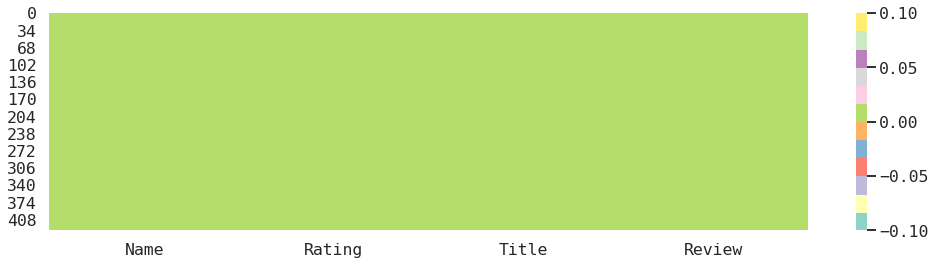

In [580]:
print("Total missing values in train dataset :",df.isnull().sum().sum())
plt.figure(figsize=(17,4))
sns.heatmap(df.isnull(),cmap="Set3")

###### unique values in columns

In [581]:
df.nunique()

Name      396
Rating      5
Title     423
Review    430
dtype: int64

###### data cleaning

In [582]:
df[['Rating', 'B']] = df['Rating'].str.split('.', expand= True) 

In [583]:
df.drop('B', axis=1, inplace=True)

In [584]:
df.drop(['Name'],axis=1,inplace=True)

In [585]:
df['Text'] = df['Review'] + ' ' + df['Title']
del df['Review']
del df['Title']

In [586]:
df['raw length']= df.Text.str.len().astype('int64')

In [587]:
def sentiment_rating(rating):
    # Replacing ratings of 1,2,3 with 0 (not good) and 4,5 with 1 (good)
    if(int(rating) == 1 or int(rating) == 2 or int(rating) == 3):
        return 0
    else: 
        return 1
df['overall'] = df.Rating.apply(sentiment_rating) 

In [588]:
df.overall.value_counts()

0    267
1    163
Name: overall, dtype: int64

In [589]:
df.Rating.value_counts()

2    96
3    92
5    83
4    80
1    79
Name: Rating, dtype: int64

In [590]:
rating_pct = df['Rating'].value_counts()/len(df) * 100

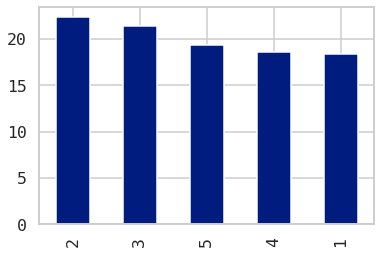

In [591]:
rating_pct.plot.bar()
plt.show()

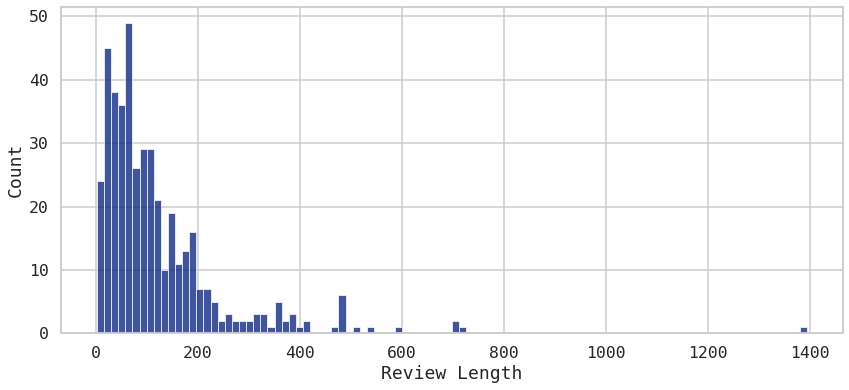

In [592]:
#words per review
plt.figure(figsize = (14,6))
WordsPerReview = df['Text'].apply(lambda x: len(x.split(' ')))

sns.histplot(WordsPerReview,bins = 100)

plt.xlabel('Review Length')
plt.show()


In [593]:
#df['Rating'] = df['Rating'].astype (int)
df = pd.get_dummies (df, columns= ['Rating'])

In [594]:
df.describe()

raw length     overall    Rating_1    Rating_2    Rating_3  \
count   430.000000  430.000000  430.000000  430.000000  430.000000   
mean    657.474419    0.379070    0.183721    0.223256    0.213953   
std     711.962924    0.485721    0.387708    0.416914    0.410572   
min      12.000000    0.000000    0.000000    0.000000    0.000000   
25%     234.000000    0.000000    0.000000    0.000000    0.000000   
50%     436.000000    0.000000    0.000000    0.000000    0.000000   
75%     837.250000    1.000000    0.000000    0.000000    0.000000   
max    7646.000000    1.000000    1.000000    1.000000    1.000000   

         Rating_4    Rating_5  
count  430.000000  430.000000  
mean     0.186047    0.193023  
std      0.389597    0.395131  
min      0.000000    0.000000  
25%      0.000000    0.000000  
50%      0.000000    0.000000  
75%      0.000000    0.000000  
max      1.000000    1.000000

In [595]:
df.head()

Text  raw length  overall  \
0  I have always been a Samsung cell phone person...         464        1   
1  Everything about the cell phone looked good. B...         875        0   
2  Mobile phones are cost-effective, high in pixe...         115        1   
3  I was hesitant to buy a brand I've never heard...         185        1   
4  Bought this for my wife and she loves it!! Its...         216        1   

   Rating_1  Rating_2  Rating_3  Rating_4  Rating_5  
0         0         0         0         0         1  
1         1         0         0         0         0  
2         0         0         0         0         1  
3         0         0         0         0         1  
4         0         0         0         0         1

In [596]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [597]:
stopwords=['i','me','my','myself','we','our','ours','ourselves','you',"you're","you've","you'll","you'd",'yo','nothin','from','bein','u','ok','yup','youve',
           'your','yours','yourself','yourselves','he','him','his','himself','she',"she's",'her','hers','ur','mlm','nbfc',"he's",'ip','ja',"there's",'tyme','yep'
           'herself','it',"it's",'its','itself','they','them','their','theirs','themselves','what','which','lol','lool','fwiw','argh',"dont","i'll",'utc','too','y','u','r','doesnt'
           'who','whom','this','that',"that'll",'these','how','these','those','am','is','are','was','were','oh','hay','thanks','ty','wc','ha','hi','d','re','ll','there','someone','say',
           'be','been','being','have','has','had','having','do','does','did','done','doing','a','an','the','even','aww','bye!','bye','e','f','and','but','if','or','because','as','until','while','of','at','by','for','with','about','against',
           'between','into','through','during','before','after','above','below','to','from','up','down','in','out','on','off','over','under','again','further','then','once','here','there','when','where','why','how',
           'all','any','both','each','few','more','most','other','some','such','no','nor','not','only','own','same','so','than','too','very','s','t','can','will','just','don',"don't",'should',"should've",'now','d','ll','m',
           'o','re','ve','y','ain','aren',"aren't",'couldn',"couldn't",'didn',"didn't",'doesn',"doesn't",'hadn',"hadn't",'hasn',"hasn't",'haven',"haven't",'isn',"isn't",'ma','mightn',"mightn't",'mustn',"mustn't",'needn',
           "needn't",'shan',"shan't",'shouldn',"shouldn't",'wasn',"wasn't",'weren',"weren't",'won',"won't",'wouldn',"wouldn't", 'looked', "what's",'although','upright','bit','right','state',"i've",'much','more',
           "there's","You've",'got',"i'd",'everything','true','yes','moreover','would','could','like','mr.','but',"i'm",'able','back','get','still','ought','perhaps','without','away','onto','ive','let',
          'must','see','went','saw','many','whats','id','let','day','never','yet','im','go','thatll','theyre','came','youll','come','word','noone',"mrs.","now!","then?",'mr','ve','Â Â','january','days','february','march','april','may','june','july','august','september',
           'october','november','december','everyone','hey','ok','okay','cant','bbq','let','thats','also','time','name','oh','said','asked','anyone','however','wow','daww']

In [598]:
def preprocess(text):
    processed=[]
    lower=text.lower().replace(r'\n'," ").replace(r'^.+@[^\.].*\.[a-z]{2,}$',' ').replace(r'^http://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',' ')
    text=lower.replace(r'\s+', ' ').replace(r'\d+(\.\d+)?', ' ')
    text=lower.replace(r"[^a-zA-Z]+", " ").replace(r"—"," ").replace(r'“', ' ').replace(r'”',' ').replace('’',' ').replace(r'–',' ').replace('«', ' ').replace('»',' ')
    text=text.replace('®',' ').replace('´',' ').replace('·',' ').replace('½',' ').replace('¾',' ').replace('¤',' ')
    punct=text.translate(str.maketrans('', '', p)) 
    digit=punct.translate(str.maketrans('', '', d))     
    word= wt(digit, "english")
    for i in word:
        if i not in stopwords and len(i)>=3 and len(i)<12:
            lemma=porter().stem(wl().lemmatize(i))
            processed.append(lemma)
    return (" ".join([x for x in processed])).strip()

In [599]:
clean = []
for i in df.Text:
    clean.append(preprocess(i))

In [600]:
print("Length of cleaned text=\t",len(clean))

Length of cleaned text=	 430


In [601]:
processed = pd.DataFrame({'comment' : clean })
df['comment']= processed
df['len of cleaned comment']=df['comment'].str.len().astype('int64')

In [602]:
print('Original Length = ',df['raw length'].sum())
print('Clean Length =  ', df['len of cleaned comment'].sum())
print('Total Reduction = ',df['raw length'].sum()-df['len of cleaned comment'].sum())

Original Length =  282714
Clean Length =   141385
Total Reduction =  141329


In [603]:
df.head()

Text  raw length  overall  \
0  I have always been a Samsung cell phone person...         464        1   
1  Everything about the cell phone looked good. B...         875        0   
2  Mobile phones are cost-effective, high in pixe...         115        1   
3  I was hesitant to buy a brand I've never heard...         185        1   
4  Bought this for my wife and she loves it!! Its...         216        1   

   Rating_1  Rating_2  Rating_3  Rating_4  Rating_5  \
0         0         0         0         0         1   
1         1         0         0         0         0   
2         0         0         0         0         1   
3         0         0         0         0         1   
4         0         0         0         0         1   

                                             comment  len of cleaned comment  
0  alway samsung cell phone person tcl phone felt...                     226  
1  cell phone good tri hold custom servic help st...                     426  
2        mobil phone high pixel excel perform worthi                      43  
3  hesit buy brand heard absolut love total worth...                      97  
4  bought wife love nice note high price well bat...                     104

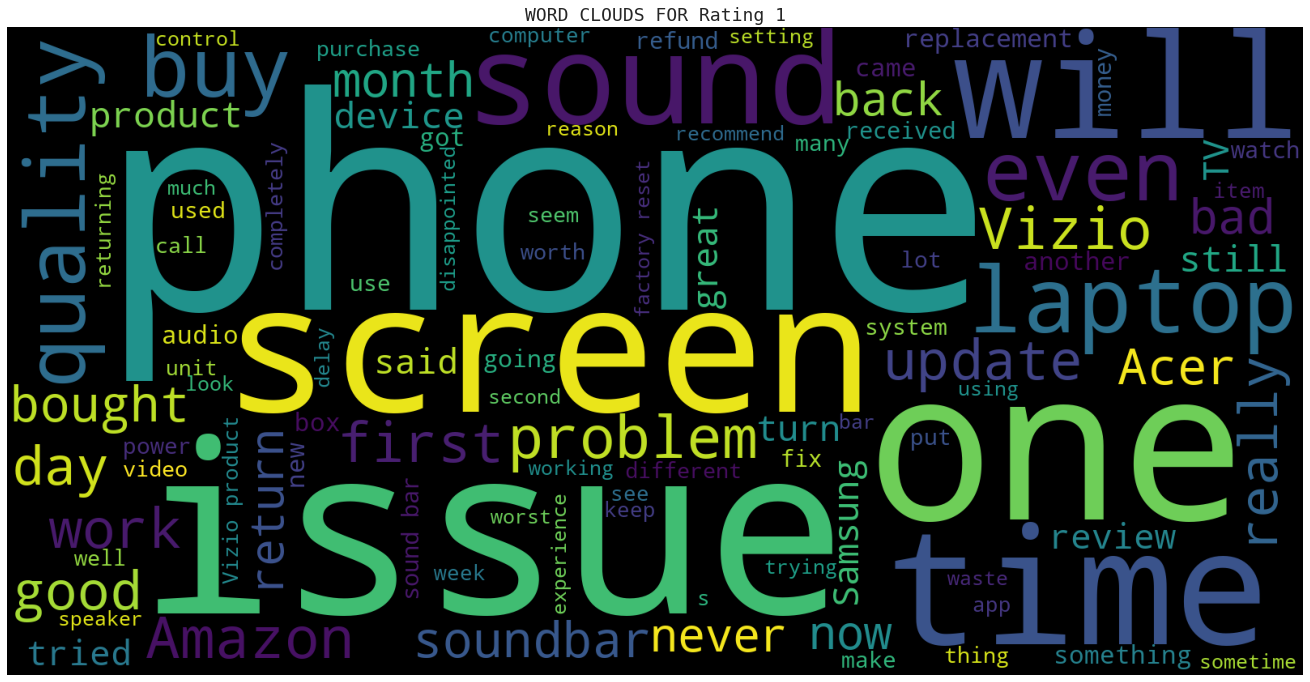

In [604]:
Rating = df['Text'][df['Rating_1']==1]
wordcloud = WordCloud(width=1600,height=800,background_color='black',max_words=100).generate(' '.join(Rating))
plt.figure(figsize = (18,9), facecolor = 'white', edgecolor='blue') 
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('WORD CLOUDS FOR Rating 1')
plt.show()

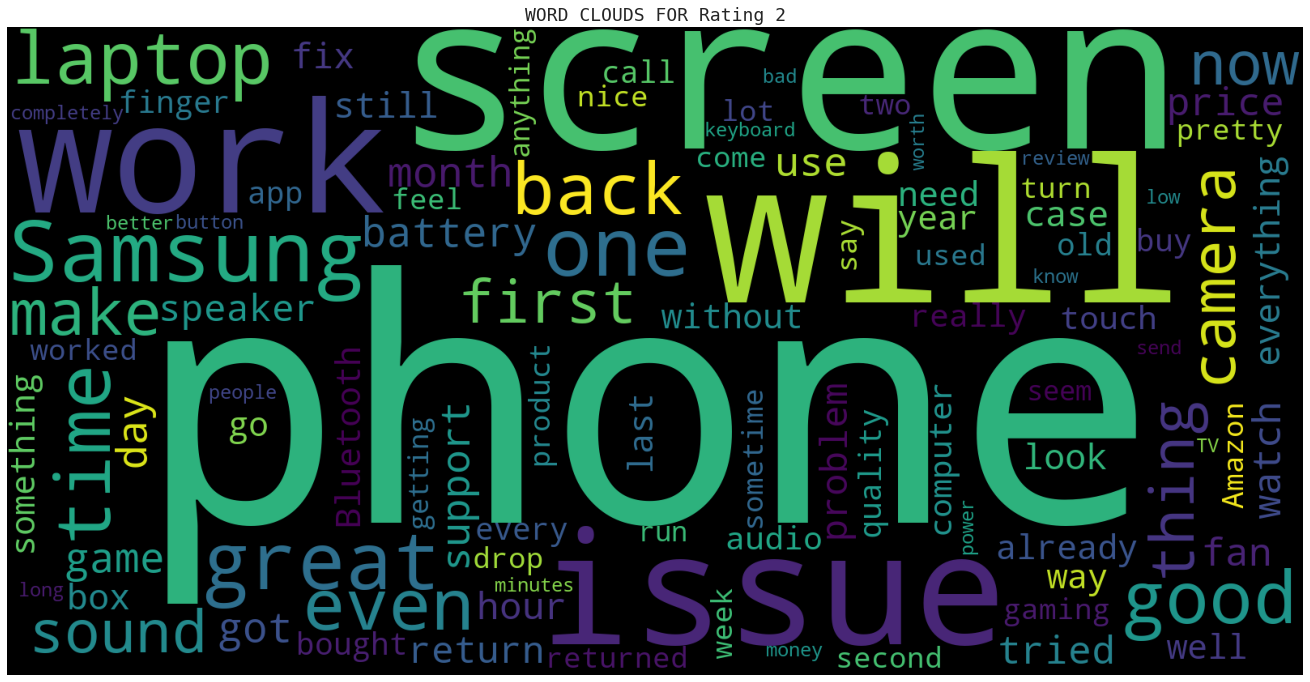

In [605]:
Rating = df['Text'][df['Rating_2']==1]
wordcloud = WordCloud(width=1600,height=800,background_color='black',max_words=100).generate(' '.join(Rating))
plt.figure(figsize = (18,9), facecolor = 'white', edgecolor='blue') 
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('WORD CLOUDS FOR Rating 2')
plt.show()

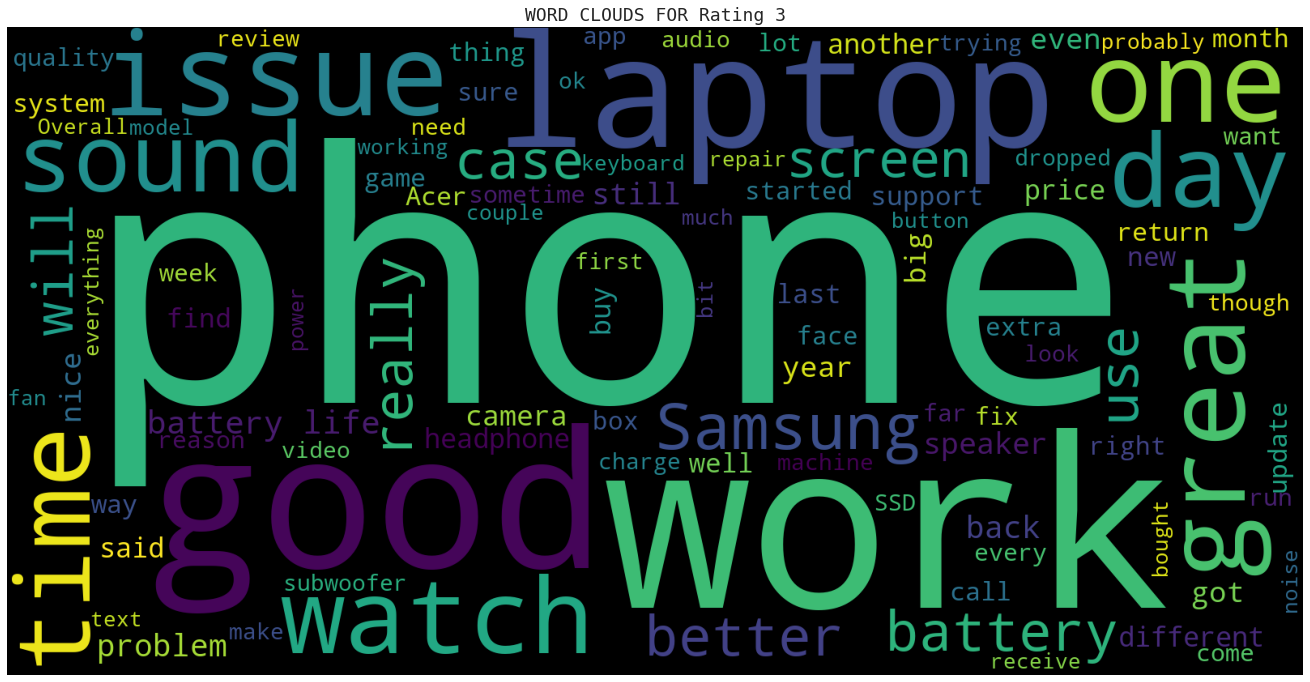

In [606]:
Rating = df['Text'][df['Rating_3']==1]
wordcloud = WordCloud(width=1600,height=800,background_color='black',max_words=100).generate(' '.join(Rating))
plt.figure(figsize = (18,9), facecolor = 'white', edgecolor='blue') 
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('WORD CLOUDS FOR Rating 3')
plt.show()

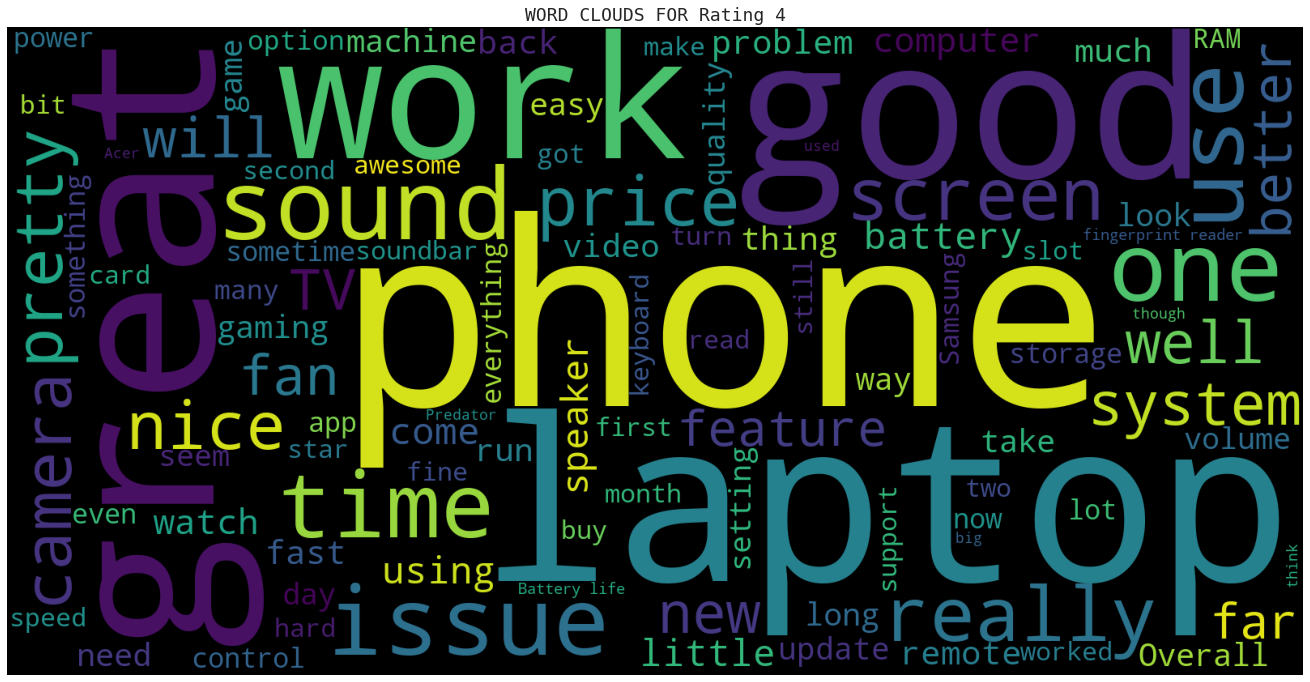

In [607]:
Rating = df['Text'][df['Rating_4']==1]
wordcloud = WordCloud(width=1600,height=800,background_color='black',max_words=100).generate(' '.join(Rating))
plt.figure(figsize = (18,9), facecolor = 'white', edgecolor='blue') 
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('WORD CLOUDS FOR Rating 4')
plt.show()

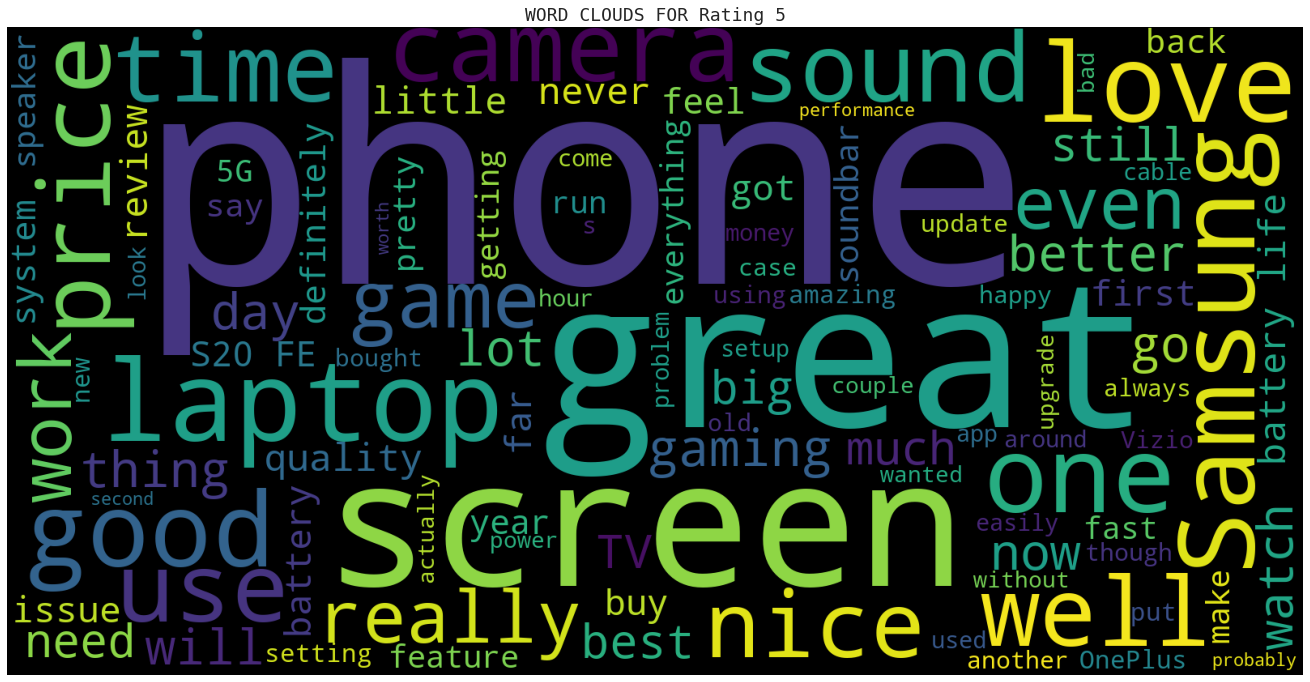

In [608]:
Rating = df['Text'][df['Rating_5']==1]
wordcloud = WordCloud(width=1600,height=800,background_color='black',max_words=100).generate(' '.join(Rating))
plt.figure(figsize = (18,9), facecolor = 'white', edgecolor='blue') 
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('WORD CLOUDS FOR Rating 5')
plt.show()

In [609]:
df.head()

Text  raw length  overall  \
0  I have always been a Samsung cell phone person...         464        1   
1  Everything about the cell phone looked good. B...         875        0   
2  Mobile phones are cost-effective, high in pixe...         115        1   
3  I was hesitant to buy a brand I've never heard...         185        1   
4  Bought this for my wife and she loves it!! Its...         216        1   

   Rating_1  Rating_2  Rating_3  Rating_4  Rating_5  \
0         0         0         0         0         1   
1         1         0         0         0         0   
2         0         0         0         0         1   
3         0         0         0         0         1   
4         0         0         0         0         1   

                                             comment  len of cleaned comment  
0  alway samsung cell phone person tcl phone felt...                     226  
1  cell phone good tri hold custom servic help st...                     426  
2        mobil phone high pixel excel perform worthi                      43  
3  hesit buy brand heard absolut love total worth...                      97  
4  bought wife love nice note high price well bat...                     104

In [610]:
X = df['comment']
#y = df['Rating']
y=df.iloc[:,2:-2]

In [611]:
y.columns

Index(['overall', 'Rating_1', 'Rating_2', 'Rating_3', 'Rating_4', 'Rating_5'], dtype='object')

In [612]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 42,test_size = 0.20)

In [613]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(344,)
(86,)
(344, 6)
(86, 6)


In [614]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier

In [615]:
tfidf_vec = TfidfVectorizer(input='content', encoding='utf-8', lowercase=True,stop_words='english',max_features=1000,ngram_range=(1,3))
#tfidf_vec = TfidfVectorizer(ngram_range=(1, 4))
tfidf_train = tfidf_vec.fit_transform(X_train)
tfidf_test = tfidf_vec.transform(X_test)

In [616]:
labels=y

Processing overall 
-------------------------------------
ACCURACY SCORE: 0.7674418604651163

F1 score: 0.5652173913043479

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.76      0.95      0.84        56
           1       0.81      0.43      0.57        30

    accuracy                           0.77        86
   macro avg       0.78      0.69      0.70        86
weighted avg       0.78      0.77      0.74        86


PRECISION:
 0.8125

RECALL:
 0.43333333333333335

MEAN SQUARED ERROR:
 0.23255813953488372

ROOT MEAN SQ. ERROR:
 0.4822428221704121

LOG_LOSS: 8.032301473145399

AUC_ROC Score:
 0.6898809523809524

TPR: [0.         0.05357143 1.        ] 
FPR: [0.         0.43333333 1.        ] 



	____________________________________________ROC_AUC CURVE_______________________________________________


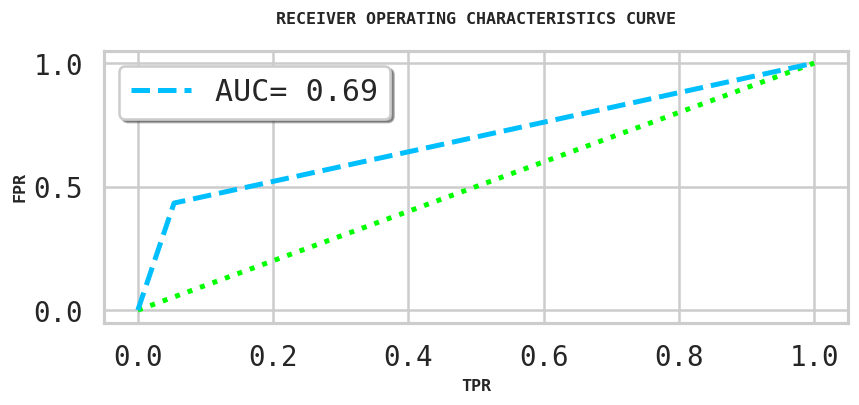




	____________________________________________CONFUSION MATRIX___________________________________________



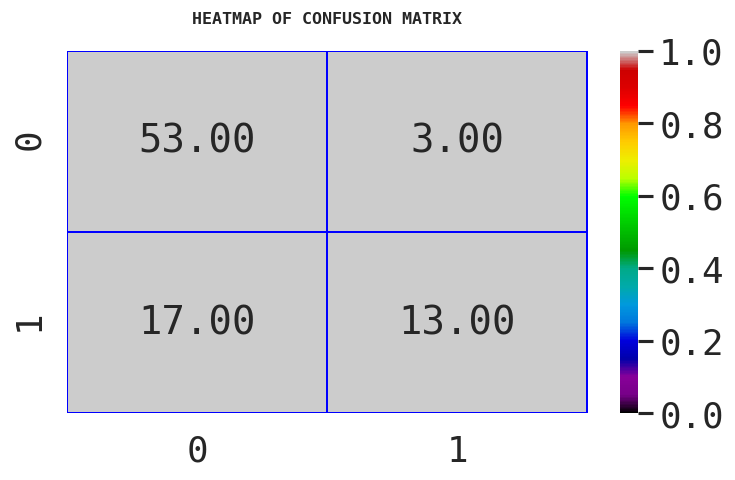



Processing Rating_1 
-------------------------------------
ACCURACY SCORE: 0.8023255813953488

F1 score: 0.0

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89        69
           1       0.00      0.00      0.00        17

    accuracy                           0.80        86
   macro avg       0.40      0.50      0.45        86
weighted avg       0.64      0.80      0.71        86


PRECISION:
 0.0

RECALL:
 0.0

MEAN SQUARED ERROR:
 0.19767441860465115

ROOT MEAN SQ. ERROR:
 0.44460591382105025

LOG_LOSS: 6.827432543180018

AUC_ROC Score:
 0.5

TPR: [0. 1.] 
FPR: [0. 1.] 



	____________________________________________ROC_AUC CURVE_______________________________________________


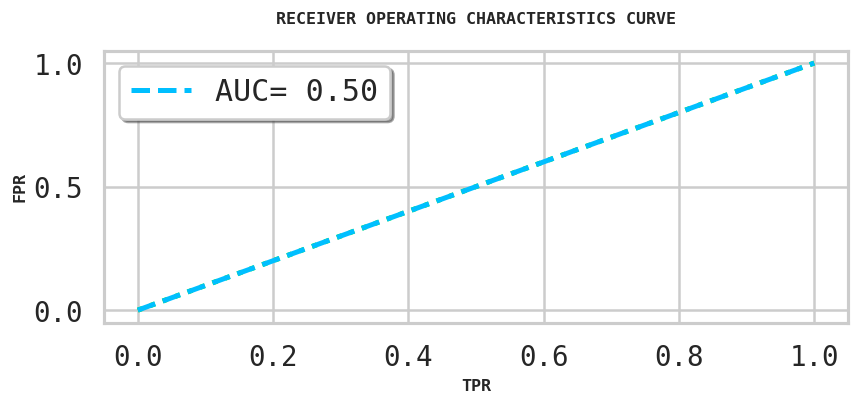




	____________________________________________CONFUSION MATRIX___________________________________________



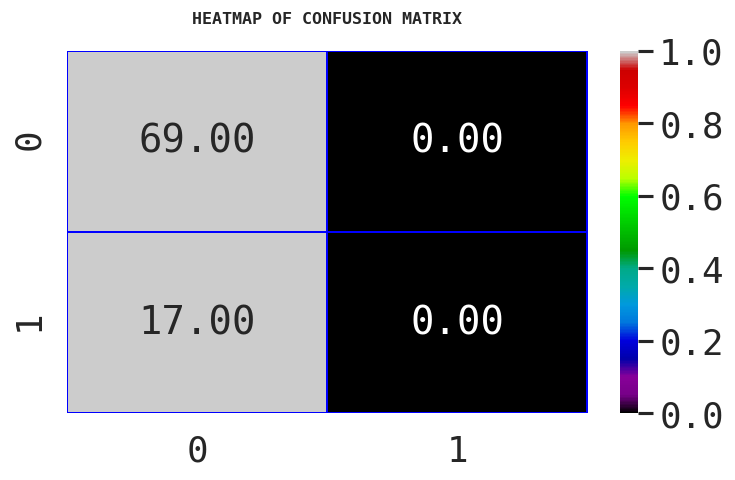



Processing Rating_2 
-------------------------------------
ACCURACY SCORE: 0.7558139534883721

F1 score: 0.0

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.76      1.00      0.86        65
           1       0.00      0.00      0.00        21

    accuracy                           0.76        86
   macro avg       0.38      0.50      0.43        86
weighted avg       0.57      0.76      0.65        86


PRECISION:
 0.0

RECALL:
 0.0

MEAN SQUARED ERROR:
 0.2441860465116279

ROOT MEAN SQ. ERROR:
 0.4941518456017623

LOG_LOSS: 8.433887259222375

AUC_ROC Score:
 0.5

TPR: [0. 1.] 
FPR: [0. 1.] 



	____________________________________________ROC_AUC CURVE_______________________________________________


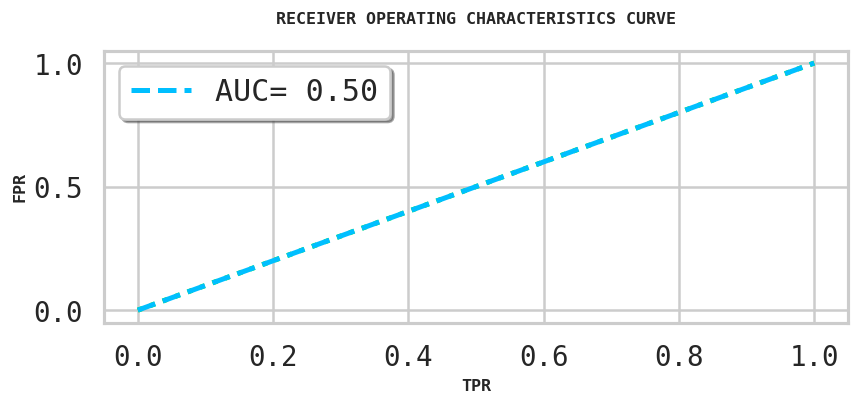




	____________________________________________CONFUSION MATRIX___________________________________________



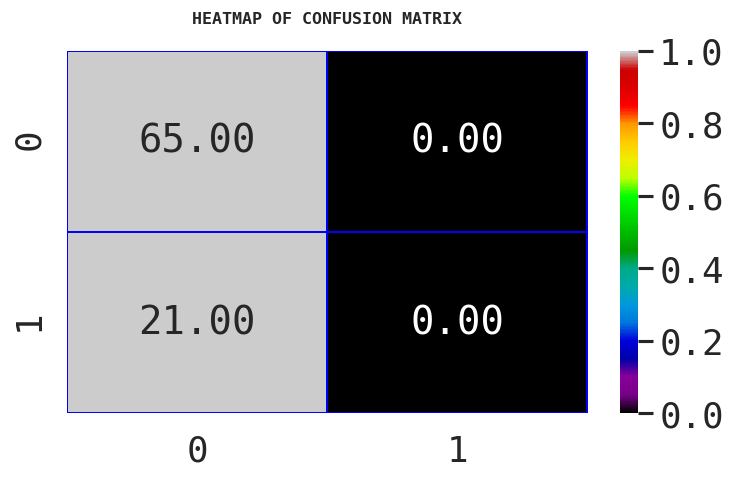



Processing Rating_3 
-------------------------------------
ACCURACY SCORE: 0.7906976744186046

F1 score: 0.0

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.79      1.00      0.88        68
           1       0.00      0.00      0.00        18

    accuracy                           0.79        86
   macro avg       0.40      0.50      0.44        86
weighted avg       0.63      0.79      0.70        86


PRECISION:
 0.0

RECALL:
 0.0

MEAN SQUARED ERROR:
 0.20930232558139536

ROOT MEAN SQ. ERROR:
 0.457495710997814

LOG_LOSS: 7.2290462221906076

AUC_ROC Score:
 0.5

TPR: [0. 1.] 
FPR: [0. 1.] 



	____________________________________________ROC_AUC CURVE_______________________________________________


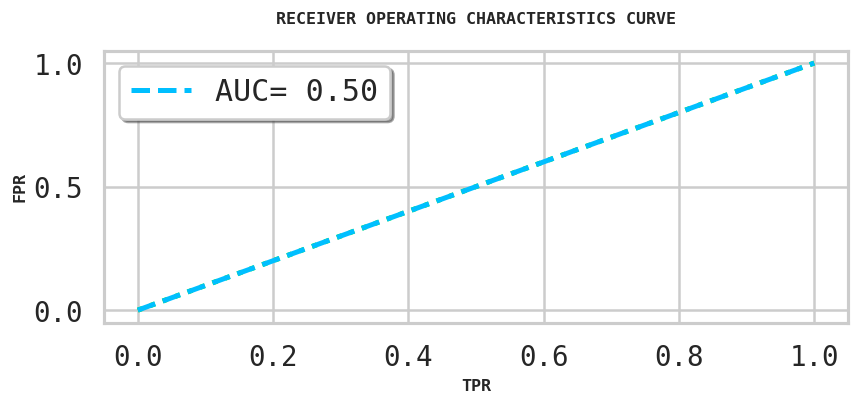




	____________________________________________CONFUSION MATRIX___________________________________________



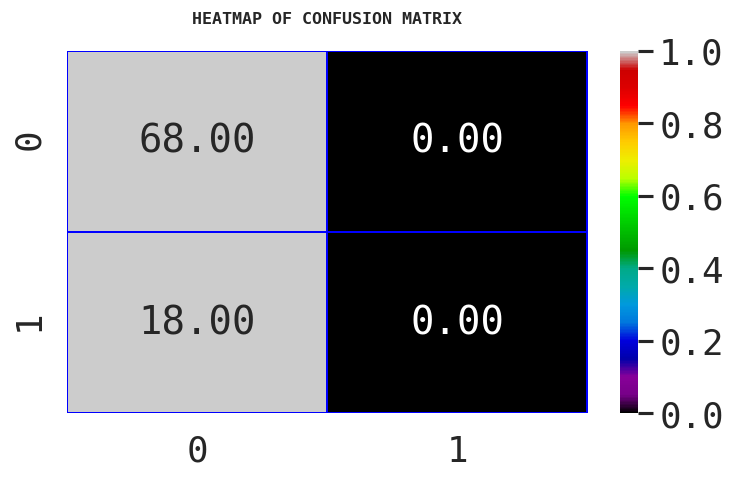



Processing Rating_4 
-------------------------------------
ACCURACY SCORE: 0.8604651162790697

F1 score: 0.0

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.86      1.00      0.92        74
           1       0.00      0.00      0.00        12

    accuracy                           0.86        86
   macro avg       0.43      0.50      0.46        86
weighted avg       0.74      0.86      0.80        86


PRECISION:
 0.0

RECALL:
 0.0

MEAN SQUARED ERROR:
 0.13953488372093023

ROOT MEAN SQ. ERROR:
 0.3735436838188142

LOG_LOSS: 4.819364148127073

AUC_ROC Score:
 0.5

TPR: [0. 1.] 
FPR: [0. 1.] 



	____________________________________________ROC_AUC CURVE_______________________________________________


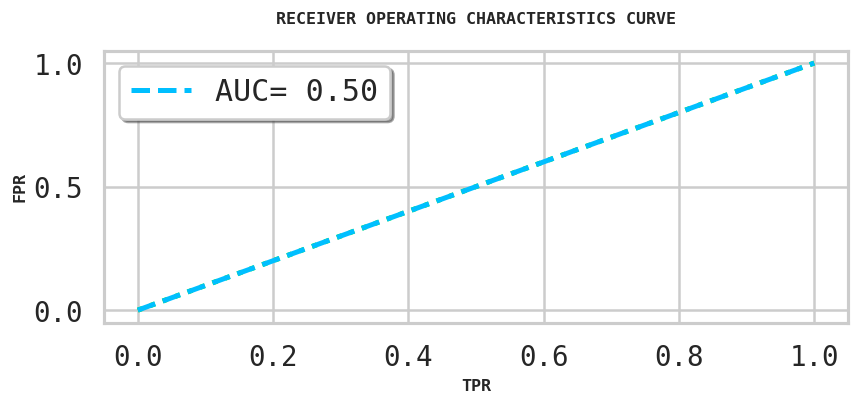




	____________________________________________CONFUSION MATRIX___________________________________________



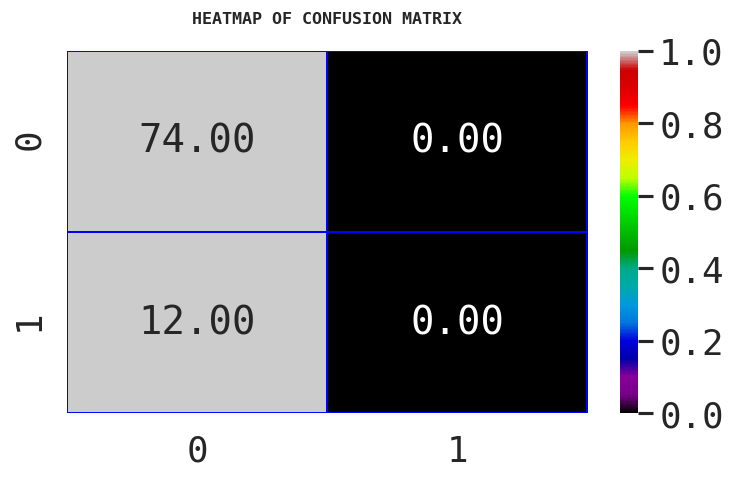



Processing Rating_5 
-------------------------------------
ACCURACY SCORE: 0.7906976744186046

F1 score: 0.0

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.79      1.00      0.88        68
           1       0.00      0.00      0.00        18

    accuracy                           0.79        86
   macro avg       0.40      0.50      0.44        86
weighted avg       0.63      0.79      0.70        86


PRECISION:
 0.0

RECALL:
 0.0

MEAN SQUARED ERROR:
 0.20930232558139536

ROOT MEAN SQ. ERROR:
 0.457495710997814

LOG_LOSS: 7.2290462221906076

AUC_ROC Score:
 0.5

TPR: [0. 1.] 
FPR: [0. 1.] 



	____________________________________________ROC_AUC CURVE_______________________________________________


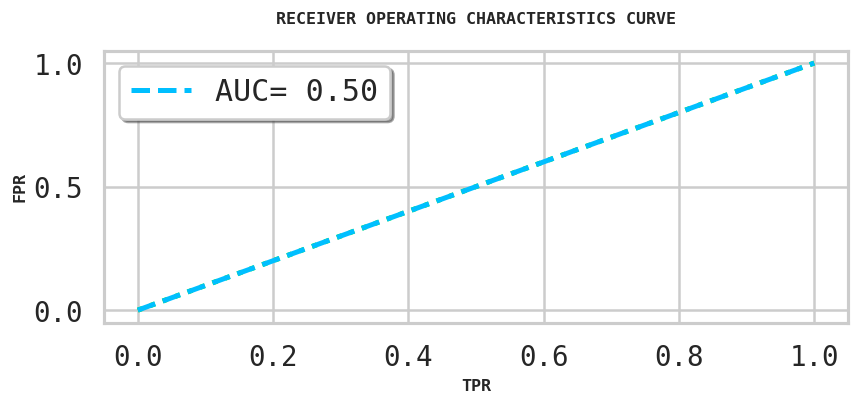




	____________________________________________CONFUSION MATRIX___________________________________________



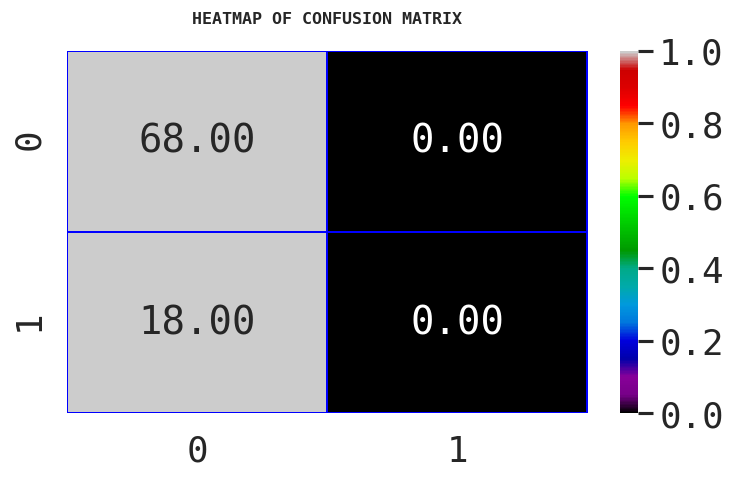

In [617]:
LogReg_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1))])
F1=[]
ACCURACY = []
PRECESION = []
RECALL = []
RMSE = []
MSE = []
AUC=[]
TPR=[]
FPR=[]
CV_ACC=[]
LOG_LOSS=[]

for category in labels:
    print('Processing {}'.format(category),"\n-------------------------------------")
    LogReg_pipeline.fit(tfidf_train, y_train[category])
    pred = LogReg_pipeline.predict(tfidf_test)
    
    f1=f1_score(pred,y_test[category])
    acc=accuracy_score(pred,y_test[category])
    clr=classification_report(y_test[category],pred)
    pre=precision_score(y_test[category],pred)
    rec=recall_score(y_test[category],pred)
    mse=mean_squared_error(y_test[category],pred)
    rmse=np.sqrt(mse)
    log = log_loss( y_test[category],pred)
    auc_scr=roc_auc_score(y_test[category],pred)
    tpr,fpr,threshold=roc_curve(y_test[category],pred)
    conf=confusion_matrix(y_test[category],pred)
    print('ACCURACY SCORE:', acc)
    print('\nF1 score:',f1)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)
    print('\nLOG_LOSS:',log)
    print('\nAUC_ROC Score:\n',auc_scr)
    print('\nTPR:',tpr,'\nFPR:',fpr,'\n')
    
    
    print('\n\n\t____________________________________________ROC_AUC CURVE_______________________________________________')
    
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(8,3),dpi=120)
    plt.plot([0,1],[0,1],color='lime',linestyle=":",lw=3)
    plt.plot(tpr,fpr,label="AUC= %0.2f" % auc_scr,color='deepskyblue',lw=3,linestyle='--')
    plt.legend(fancybox=True,shadow=True, fontsize='medium')
    
    plt.xlabel("TPR",weight='bold',fontsize=10)
    plt.ylabel('FPR',weight='bold',fontsize=10)
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE\n',size=10,weight='bold',loc='center')
    plt.show()
    
    
    print('\n\n\n\t____________________________________________CONFUSION MATRIX___________________________________________\n')
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1.3)
    plt.figure(figsize=(7,4),dpi=120)
    sns.heatmap(conf,annot=True,fmt='.2f',vmax=1,vmin=0,cmap='nipy_spectral',linewidths=0.8, linecolor='blue')
    plt.title('HEATMAP OF CONFUSION MATRIX\n',size=10,weight='bold',loc='center')
    plt.show()
    print('\n')
    
    ACCURACY.append(acc)
    F1.append(f1)
    PRECESION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    AUC.append(auc_scr)
    TPR.append(tpr)
    FPR.append(fpr)
    LOG_LOSS.append(log)

logi_results = pd.DataFrame({"LABELS":labels,"F1":F1,'Acuracy':ACCURACY,'Precision': PRECESION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,'AUC':AUC,'LOG_LOSS':LOG_LOSS})
logi_results.style.set_properties(**{'background-color':'midnightblue','color': 'lime','border-color': 'darkorange'})

Processing overall 
-------------------------------------
ACCURACY SCORE: 0.7209302325581395

F1 score: 0.6129032258064516

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.80      0.77      0.78        56
           1       0.59      0.63      0.61        30

    accuracy                           0.72        86
   macro avg       0.70      0.70      0.70        86
weighted avg       0.73      0.72      0.72        86


PRECISION:
 0.59375

RECALL:
 0.6333333333333333

MEAN SQUARED ERROR:
 0.27906976744186046

ROOT MEAN SQ. ERROR:
 0.5282705437953743

LOG_LOSS: 9.638849165633127

AUC_ROC Score:
 0.7005952380952379

TPR: [0.         0.23214286 1.        ] 
FPR: [0.         0.63333333 1.        ]



	____________________________________________ROC_AUC CURVE_______________________________________________


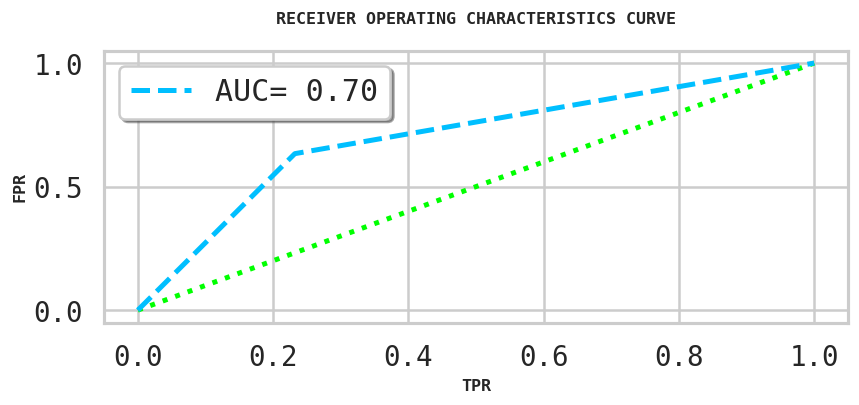




	____________________________________________CONFUSION MATRIX___________________________________________



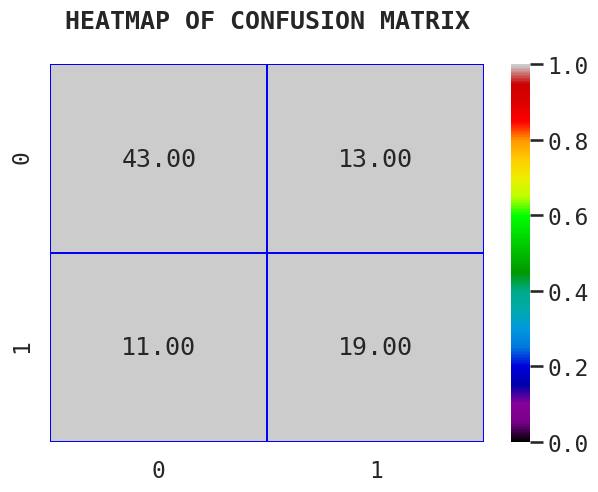



Processing Rating_1 
-------------------------------------
ACCURACY SCORE: 0.8023255813953488

F1 score: 0.45161290322580644

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88        69
           1       0.50      0.41      0.45        17

    accuracy                           0.80        86
   macro avg       0.68      0.66      0.67        86
weighted avg       0.79      0.80      0.79        86


PRECISION:
 0.5

RECALL:
 0.4117647058823529

MEAN SQUARED ERROR:
 0.19767441860465115

ROOT MEAN SQ. ERROR:
 0.44460591382105025

LOG_LOSS: 6.8274976266917795

AUC_ROC Score:
 0.655157715260017

TPR: [0.         0.10144928 1.        ] 
FPR: [0.         0.41176471 1.        ]



	____________________________________________ROC_AUC CURVE_______________________________________________


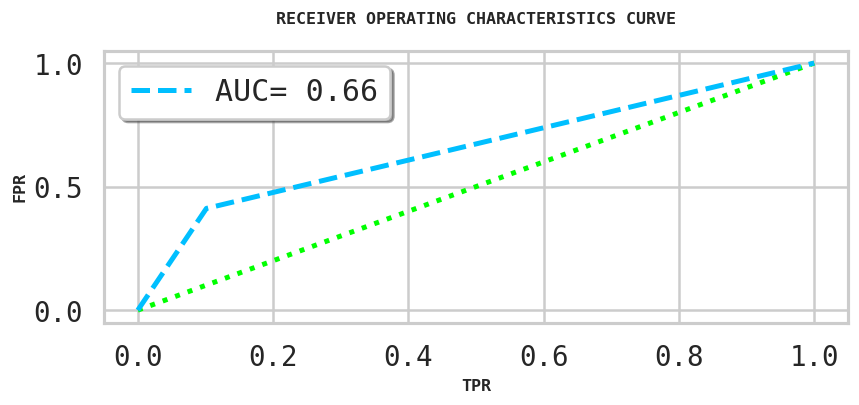




	____________________________________________CONFUSION MATRIX___________________________________________



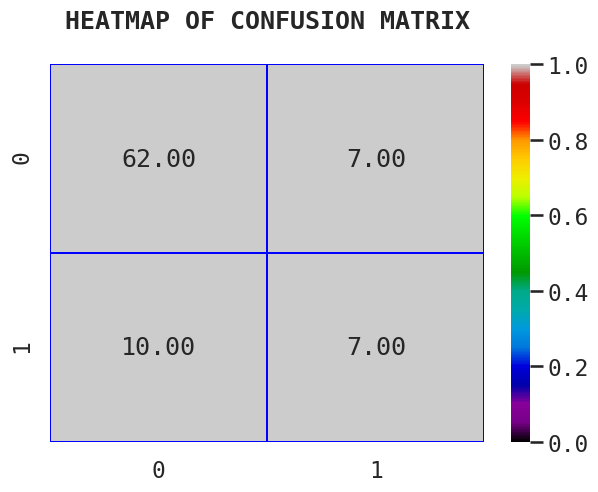



Processing Rating_2 
-------------------------------------
ACCURACY SCORE: 0.7093023255813954

F1 score: 0.24242424242424246

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.77      0.88      0.82        65
           1       0.33      0.19      0.24        21

    accuracy                           0.71        86
   macro avg       0.55      0.53      0.53        86
weighted avg       0.66      0.71      0.68        86


PRECISION:
 0.3333333333333333

RECALL:
 0.19047619047619047

MEAN SQUARED ERROR:
 0.29069767441860467

ROOT MEAN SQ. ERROR:
 0.5391638660171921

LOG_LOSS: 10.04041635642103

AUC_ROC Score:
 0.5336996336996337

TPR: [0.         0.12307692 1.        ] 
FPR: [0.         0.19047619 1.        ]



	____________________________________________ROC_AUC CURVE_______________________________________________


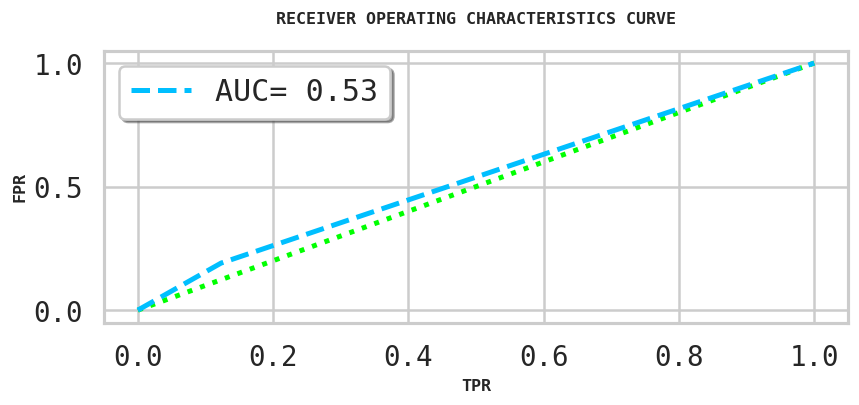




	____________________________________________CONFUSION MATRIX___________________________________________



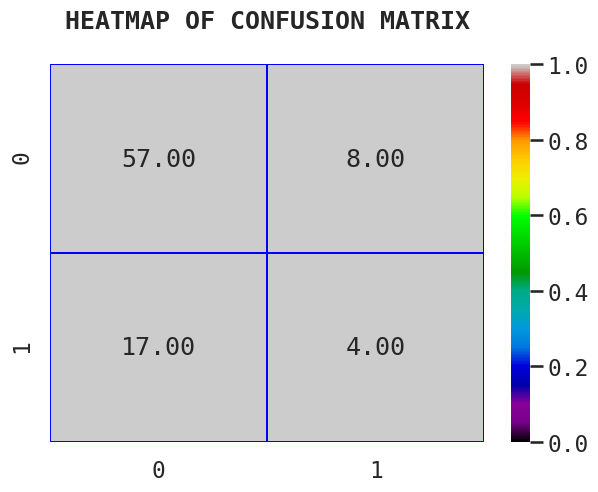



Processing Rating_3 
-------------------------------------
ACCURACY SCORE: 0.7441860465116279

F1 score: 0.08333333333333333

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.79      0.93      0.85        68
           1       0.17      0.06      0.08        18

    accuracy                           0.74        86
   macro avg       0.48      0.49      0.47        86
weighted avg       0.66      0.74      0.69        86


PRECISION:
 0.16666666666666666

RECALL:
 0.05555555555555555

MEAN SQUARED ERROR:
 0.2558139534883721

ROOT MEAN SQ. ERROR:
 0.5057805388588732

LOG_LOSS: 8.83554742645565

AUC_ROC Score:
 0.49101307189542487

TPR: [0.         0.07352941 1.        ] 
FPR: [0.         0.05555556 1.        ]



	____________________________________________ROC_AUC CURVE_______________________________________________


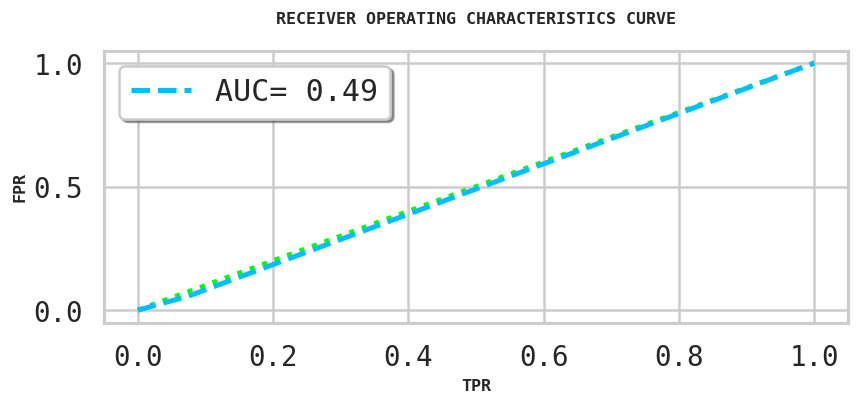




	____________________________________________CONFUSION MATRIX___________________________________________



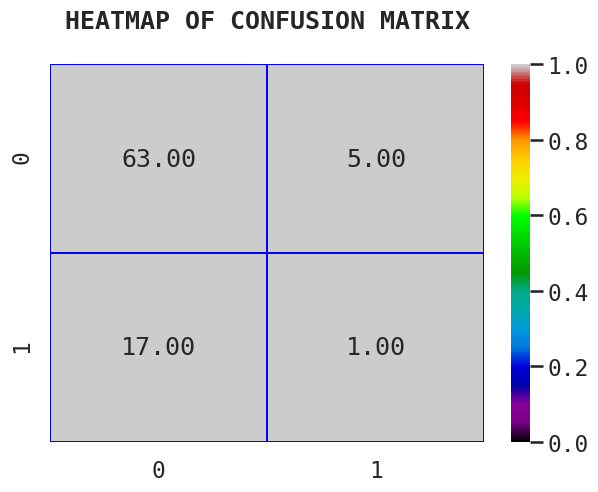



Processing Rating_4 
-------------------------------------
ACCURACY SCORE: 0.8023255813953488

F1 score: 0.2608695652173913

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.88      0.89      0.89        74
           1       0.27      0.25      0.26        12

    accuracy                           0.80        86
   macro avg       0.58      0.57      0.57        86
weighted avg       0.80      0.80      0.80        86


PRECISION:
 0.2727272727272727

RECALL:
 0.25

MEAN SQUARED ERROR:
 0.19767441860465115

ROOT MEAN SQ. ERROR:
 0.44460591382105025

LOG_LOSS: 6.827506924336316

AUC_ROC Score:
 0.5709459459459459

TPR: [0.         0.10810811 1.        ] 
FPR: [0.   0.25 1.  ]



	____________________________________________ROC_AUC CURVE_______________________________________________


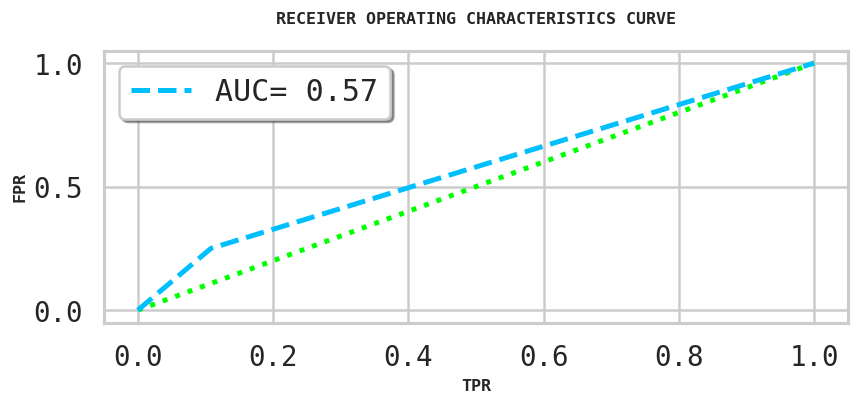




	____________________________________________CONFUSION MATRIX___________________________________________



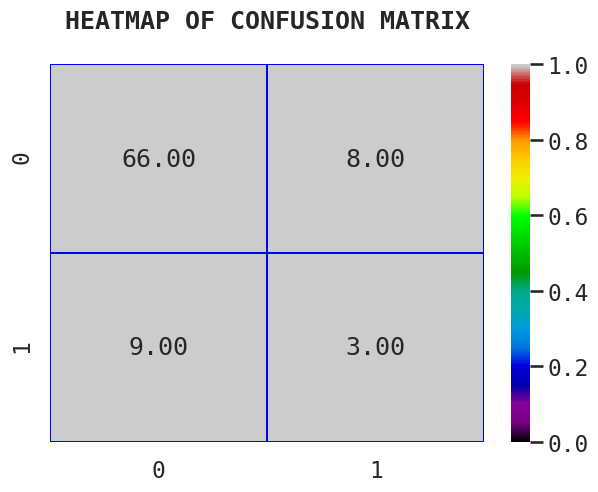



Processing Rating_5 
-------------------------------------
ACCURACY SCORE: 0.7906976744186046

F1 score: 0.30769230769230765

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.82      0.94      0.88        68
           1       0.50      0.22      0.31        18

    accuracy                           0.79        86
   macro avg       0.66      0.58      0.59        86
weighted avg       0.75      0.79      0.76        86


PRECISION:
 0.5

RECALL:
 0.2222222222222222

MEAN SQUARED ERROR:
 0.20930232558139536

ROOT MEAN SQ. ERROR:
 0.457495710997814

LOG_LOSS: 7.229083412768756

AUC_ROC Score:
 0.5816993464052288

TPR: [0.         0.05882353 1.        ] 
FPR: [0.         0.22222222 1.        ]



	____________________________________________ROC_AUC CURVE_______________________________________________


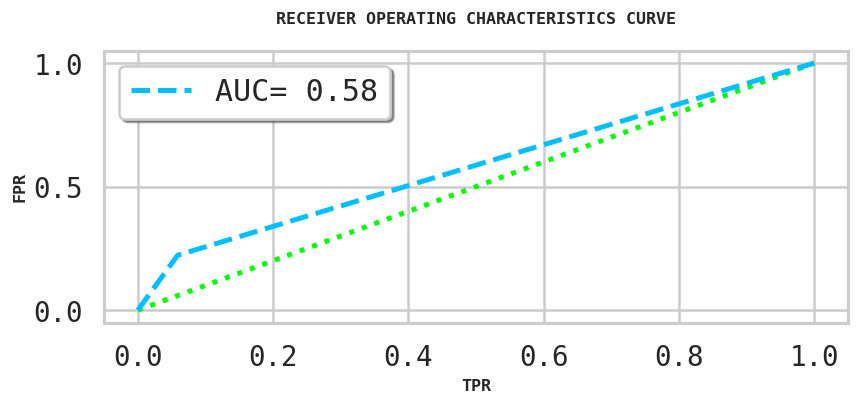




	____________________________________________CONFUSION MATRIX___________________________________________



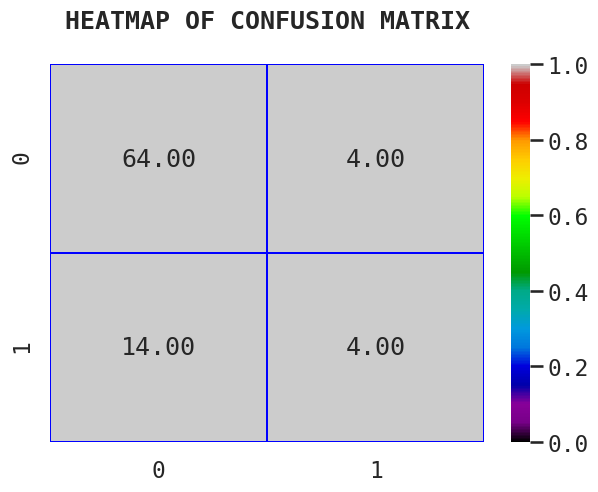

In [618]:
pac_pipeline = Pipeline([('clf', OneVsRestClassifier(PassiveAggressiveClassifier(), n_jobs=1))])
F1=[]
ACCURACY = []
PRECESION = []
RECALL = []
RMSE = []
MSE = []
AUC=[]
TPR=[]
FPR=[]
CV_ACC=[]
LOG_LOSS=[]
for category in labels:
    print('Processing {}'.format(category),'\n-------------------------------------')
    pac_pipeline.fit(tfidf_train, y_train[category])
    pred = pac_pipeline.predict(tfidf_test)
    f1=f1_score(pred,y_test[category])
    acc=accuracy_score(pred,y_test[category])
    clr=classification_report(y_test[category],pred)
    pre=precision_score(y_test[category],pred)
    rec=recall_score(y_test[category],pred)
    mse=mean_squared_error(y_test[category],pred)
    rmse=np.sqrt(mse)
    log = log_loss( y_test[category],pred)
    auc_scr=roc_auc_score(y_test[category],pred)
    tpr,fpr,threshold=roc_curve(y_test[category],pred)
    conf=confusion_matrix(y_test[category],pred)
    print('ACCURACY SCORE:', acc)
    print('\nF1 score:',f1)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)
    print('\nLOG_LOSS:',log)
    print('\nAUC_ROC Score:\n',auc_scr)
    print('\nTPR:',tpr,'\nFPR:',fpr)
        
    print('\n\n\n\t____________________________________________ROC_AUC CURVE_______________________________________________')
   
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(8,3),dpi=120)
    plt.plot([0,1],[0,1],color='lime',linestyle=":",lw=3)
    plt.plot(tpr,fpr,label="AUC= %0.2f" % auc_scr,color='deepskyblue',lw=3,linestyle='--')
    plt.legend(fancybox=True,shadow=True, fontsize='medium')
    
    plt.xlabel("TPR",weight='bold',fontsize=10)
    plt.ylabel('FPR',weight='bold',fontsize=10)
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE\n',size=10,weight='bold',loc='center')
    plt.show()
    
    print('\n\n\n\t____________________________________________CONFUSION MATRIX___________________________________________\n')
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(7,5),dpi=100)
    sns.heatmap(conf,annot=True,fmt='.2f',vmax=1,vmin=0,cmap='nipy_spectral',linewidths=0.8, linecolor='blue')
    plt.title('HEATMAP OF CONFUSION MATRIX\n',size=18,weight='bold',loc='center')
    plt.show()
    print('\n')
    
    ACCURACY.append(acc)
    F1.append(f1)
    PRECESION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    AUC.append(auc_scr)
    TPR.append(tpr)
    FPR.append(fpr)
    LOG_LOSS.append(log)

pac_results = pd.DataFrame({"LABELS":labels,"F1":F1,'Acuracy':ACCURACY,'Precision': PRECESION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,'AUC':AUC,'LOG_LOSS':LOG_LOSS})
pac_results.style.set_properties(**{'background-color':'black','color': 'lime','border-color': 'darkorange'})   

Processing overall
-------------------------------------
ACCURACY SCORE: 0.7558139534883721

F1 score: 0.5333333333333333

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.75      0.95      0.83        56
           1       0.80      0.40      0.53        30

    accuracy                           0.76        86
   macro avg       0.77      0.67      0.68        86
weighted avg       0.77      0.76      0.73        86


PRECISION:
 0.8

RECALL:
 0.4

MEAN SQUARED ERROR:
 0.2441860465116279

ROOT MEAN SQ. ERROR:
 0.4941518456017623

LOG_LOSS: 8.433915152155988

AUC_ROC Score:
 0.6732142857142857

TPR: [0.         0.05357143 1.        ] 
FPR: [0.  0.4 1. ]



	____________________________________________ROC_AUC CURVE_______________________________________________



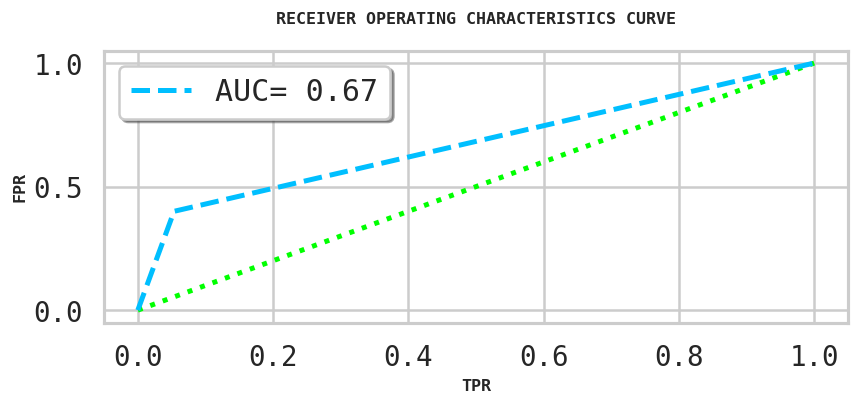




	____________________________________________CONFUSION MATRIX___________________________________________



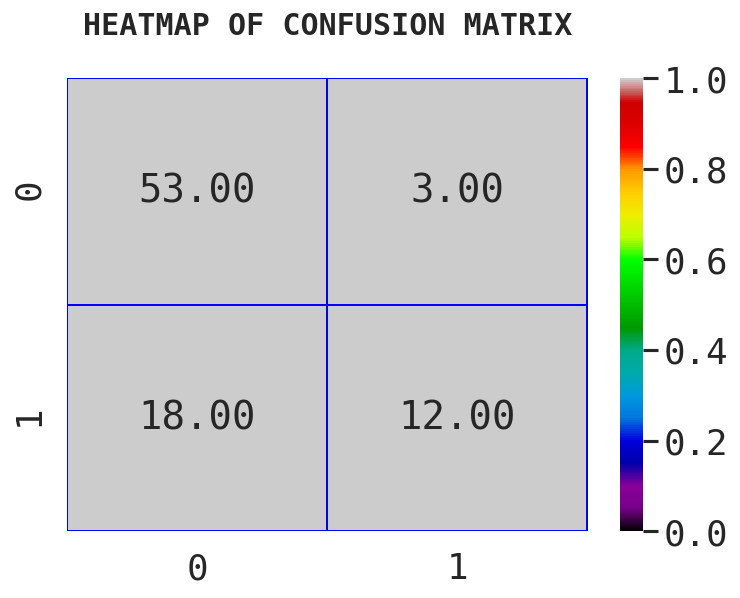



Processing Rating_1
-------------------------------------
ACCURACY SCORE: 0.7906976744186046

F1 score: 0.0

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.80      0.99      0.88        69
           1       0.00      0.00      0.00        17

    accuracy                           0.79        86
   macro avg       0.40      0.49      0.44        86
weighted avg       0.64      0.79      0.71        86


PRECISION:
 0.0

RECALL:
 0.0

MEAN SQUARED ERROR:
 0.20930232558139536

ROOT MEAN SQ. ERROR:
 0.457495710997814

LOG_LOSS: 7.229055519835145

AUC_ROC Score:
 0.4927536231884058

TPR: [0.         0.01449275 1.        ] 
FPR: [0. 0. 1.]



	____________________________________________ROC_AUC CURVE_______________________________________________



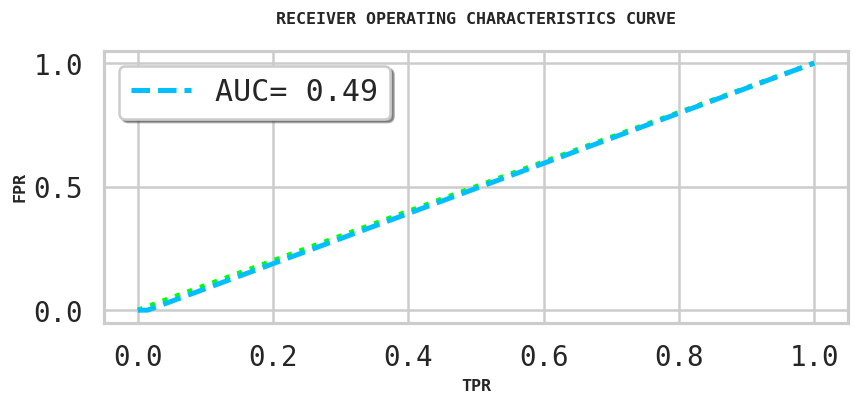




	____________________________________________CONFUSION MATRIX___________________________________________



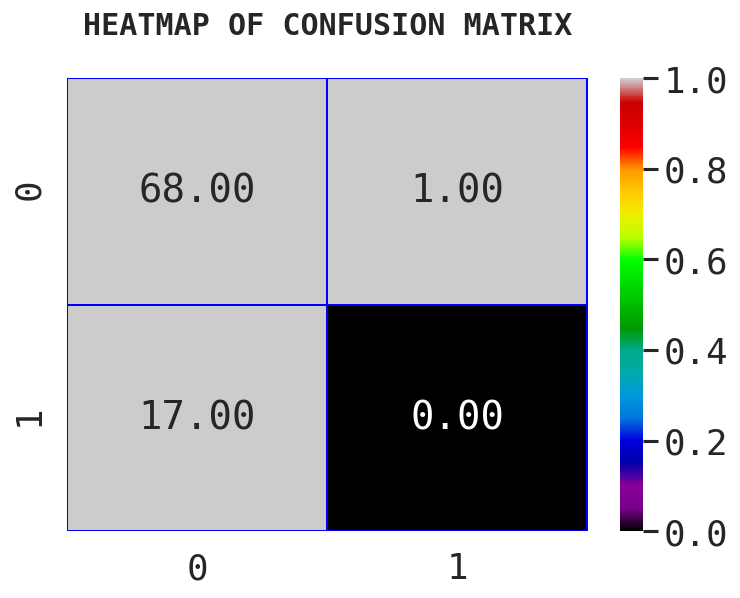



Processing Rating_2
-------------------------------------
ACCURACY SCORE: 0.7558139534883721

F1 score: 0.0

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.76      1.00      0.86        65
           1       0.00      0.00      0.00        21

    accuracy                           0.76        86
   macro avg       0.38      0.50      0.43        86
weighted avg       0.57      0.76      0.65        86


PRECISION:
 0.0

RECALL:
 0.0

MEAN SQUARED ERROR:
 0.2441860465116279

ROOT MEAN SQ. ERROR:
 0.4941518456017623

LOG_LOSS: 8.433887259222375

AUC_ROC Score:
 0.5

TPR: [0. 1.] 
FPR: [0. 1.]



	____________________________________________ROC_AUC CURVE_______________________________________________



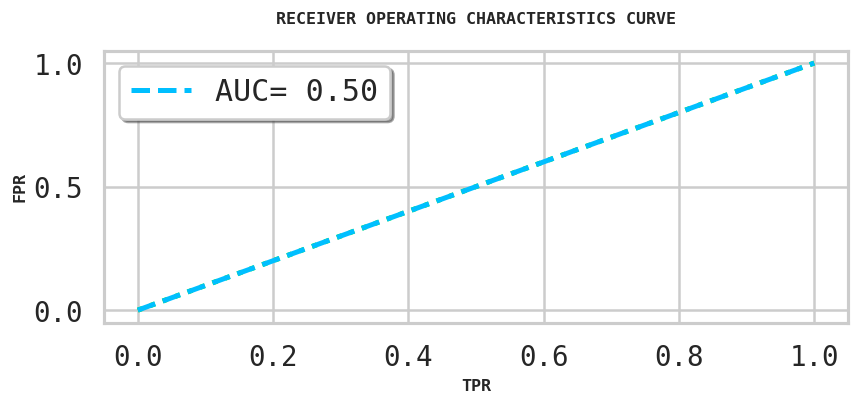




	____________________________________________CONFUSION MATRIX___________________________________________



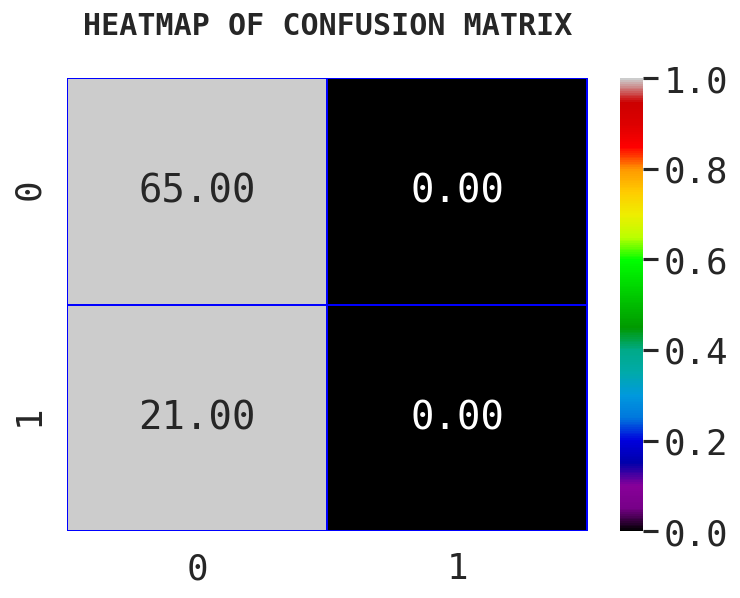



Processing Rating_3
-------------------------------------
ACCURACY SCORE: 0.7906976744186046

F1 score: 0.0

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.79      1.00      0.88        68
           1       0.00      0.00      0.00        18

    accuracy                           0.79        86
   macro avg       0.40      0.50      0.44        86
weighted avg       0.63      0.79      0.70        86


PRECISION:
 0.0

RECALL:
 0.0

MEAN SQUARED ERROR:
 0.20930232558139536

ROOT MEAN SQ. ERROR:
 0.457495710997814

LOG_LOSS: 7.2290462221906076

AUC_ROC Score:
 0.5

TPR: [0. 1.] 
FPR: [0. 1.]



	____________________________________________ROC_AUC CURVE_______________________________________________



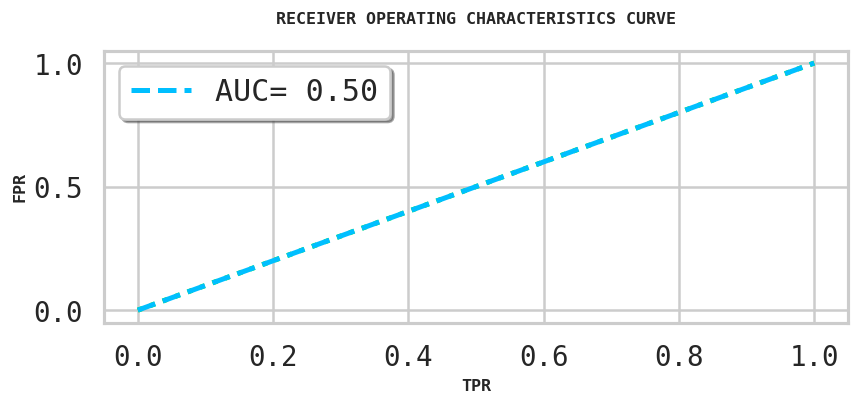




	____________________________________________CONFUSION MATRIX___________________________________________



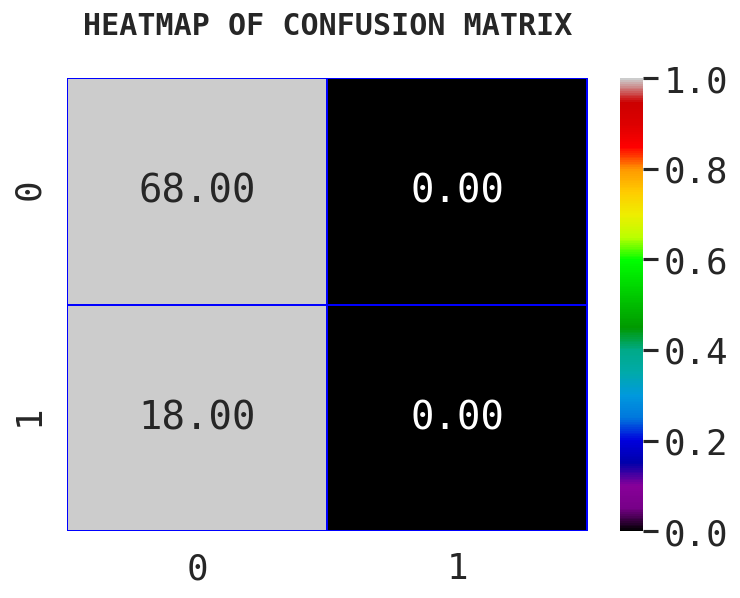



Processing Rating_4
-------------------------------------
ACCURACY SCORE: 0.8604651162790697

F1 score: 0.0

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.86      1.00      0.92        74
           1       0.00      0.00      0.00        12

    accuracy                           0.86        86
   macro avg       0.43      0.50      0.46        86
weighted avg       0.74      0.86      0.80        86


PRECISION:
 0.0

RECALL:
 0.0

MEAN SQUARED ERROR:
 0.13953488372093023

ROOT MEAN SQ. ERROR:
 0.3735436838188142

LOG_LOSS: 4.819364148127073

AUC_ROC Score:
 0.5

TPR: [0. 1.] 
FPR: [0. 1.]



	____________________________________________ROC_AUC CURVE_______________________________________________



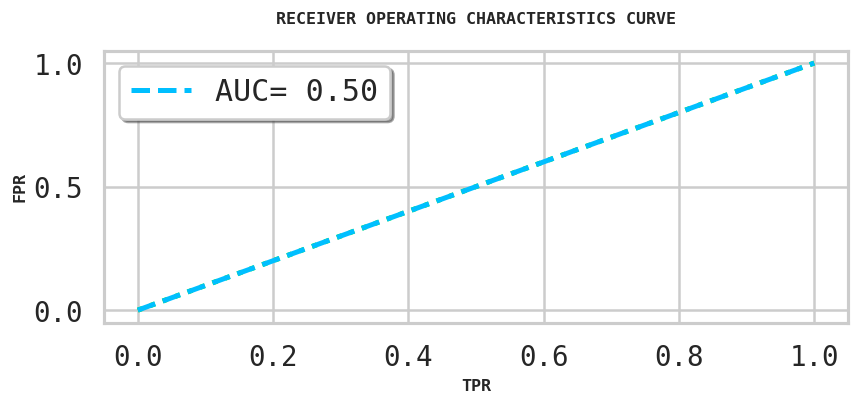




	____________________________________________CONFUSION MATRIX___________________________________________



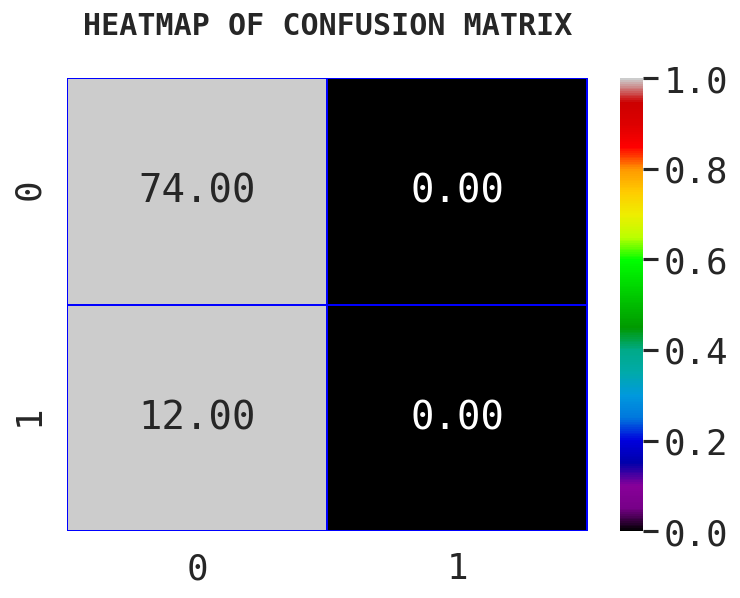



Processing Rating_5
-------------------------------------
ACCURACY SCORE: 0.7906976744186046

F1 score: 0.0

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.79      1.00      0.88        68
           1       0.00      0.00      0.00        18

    accuracy                           0.79        86
   macro avg       0.40      0.50      0.44        86
weighted avg       0.63      0.79      0.70        86


PRECISION:
 0.0

RECALL:
 0.0

MEAN SQUARED ERROR:
 0.20930232558139536

ROOT MEAN SQ. ERROR:
 0.457495710997814

LOG_LOSS: 7.2290462221906076

AUC_ROC Score:
 0.5

TPR: [0. 1.] 
FPR: [0. 1.]



	____________________________________________ROC_AUC CURVE_______________________________________________



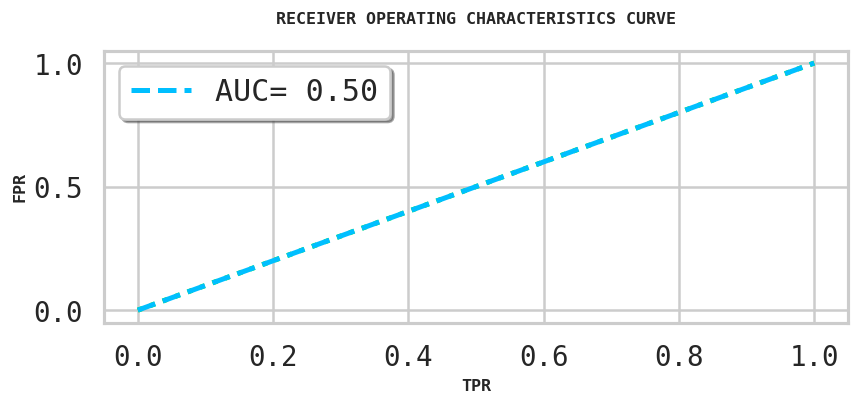




	____________________________________________CONFUSION MATRIX___________________________________________



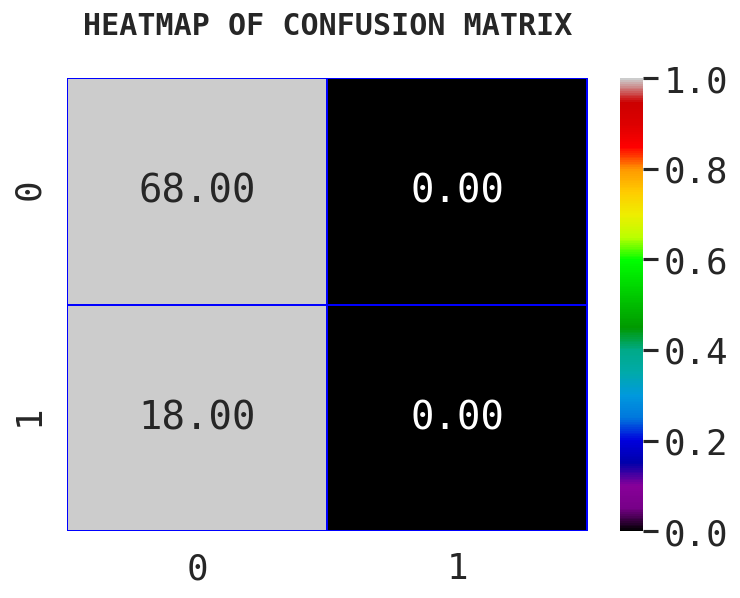

In [620]:
MNB_pipeline = Pipeline([('clf', OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None), n_jobs=-1))])
F1=[]
ACCURACY = []
PRECESION = []
RECALL = []
RMSE = []
MSE = []
AUC=[]
TPR=[]
FPR=[]
CV_ACC=[]
LOG_LOSS=[]
for category in labels:
    print('Processing {}'.format(category))
    print('-------------------------------------')
    MNB_pipeline.fit(tfidf_train, y_train[category])
    pred = MNB_pipeline.predict(tfidf_test)
    f1=f1_score(pred,y_test[category])
    acc=accuracy_score(pred,y_test[category])
    clr=classification_report(y_test[category],pred)
    pre=precision_score(y_test[category],pred)
    rec=recall_score(y_test[category],pred)
    mse=mean_squared_error(y_test[category],pred)
    rmse=np.sqrt(mse)
    log = log_loss( y_test[category],pred)
    auc_scr=roc_auc_score(y_test[category],pred)
    tpr,fpr,threshold=roc_curve(y_test[category],pred)
    conf=confusion_matrix(y_test[category],pred)
    
    print('ACCURACY SCORE:', acc)
    print('\nF1 score:',f1)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)
    print('\nLOG_LOSS:',log)
    print('\nAUC_ROC Score:\n',auc_scr)
    print('\nTPR:',tpr,'\nFPR:',fpr)
    
    print('\n\n\n\t____________________________________________ROC_AUC CURVE_______________________________________________')
    print()
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(8,3),dpi=120)
    plt.plot([0,1],[0,1],color='lime',linestyle=":",lw=3)
    plt.plot(tpr,fpr,label="AUC= %0.2f" % auc_scr,color='deepskyblue',lw=3,linestyle='--')
    plt.legend(fancybox=True,shadow=True, fontsize='medium')
    
    plt.xlabel("TPR",weight='bold',fontsize=10)
    plt.ylabel('FPR',weight='bold',fontsize=10)
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE\n',size=10,weight='bold',loc='center')
    plt.show()
    
    print('\n\n\n\t____________________________________________CONFUSION MATRIX___________________________________________\n')
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1.3)
    plt.figure(figsize=(7,5),dpi=120)
    sns.heatmap(conf,annot=True,fmt='.2f',vmax=1,vmin=0,cmap='nipy_spectral',linewidths=0.8, linecolor='blue')
    plt.title('HEATMAP OF CONFUSION MATRIX\n',size=18,weight='bold',loc='center')
    plt.show()
    print('\n')
    
    ACCURACY.append(acc)
    F1.append(f1)
    PRECESION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    AUC.append(auc_scr)
    TPR.append(tpr)
    FPR.append(fpr)
    LOG_LOSS.append(log)

mnb_results = pd.DataFrame({"LABELS":labels,"F1":F1,'Acuracy':ACCURACY,'Precision': PRECESION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,'AUC':AUC,'LOG_LOSS':LOG_LOSS})
mnb_results.style.set_properties(**{'background-color':'black','color': 'lime','border-color': 'darkorange'})


Processing overall 
-------------------------------------
ACCURACY SCORE: 0.7093023255813954

F1 score: 0.626865671641791

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.82      0.71      0.76        56
           1       0.57      0.70      0.63        30

    accuracy                           0.71        86
   macro avg       0.69      0.71      0.69        86
weighted avg       0.73      0.71      0.71        86


PRECISION:
 0.5675675675675675

RECALL:
 0.7

MEAN SQUARED ERROR:
 0.29069767441860467

ROOT MEAN SQ. ERROR:
 0.5391638660171921

LOG_LOSS: 10.040490737577327

AUC_ROC Score:
 0.7071428571428571

TPR: [0.         0.28571429 1.        ] 
FPR: [0.  0.7 1. ]



	____________________________________________ROC_AUC CURVE_______________________________________________


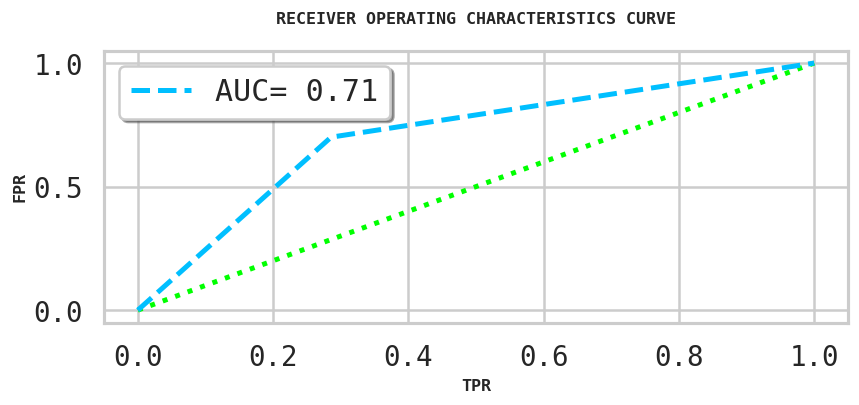




	____________________________________________CONFUSION MATRIX___________________________________________



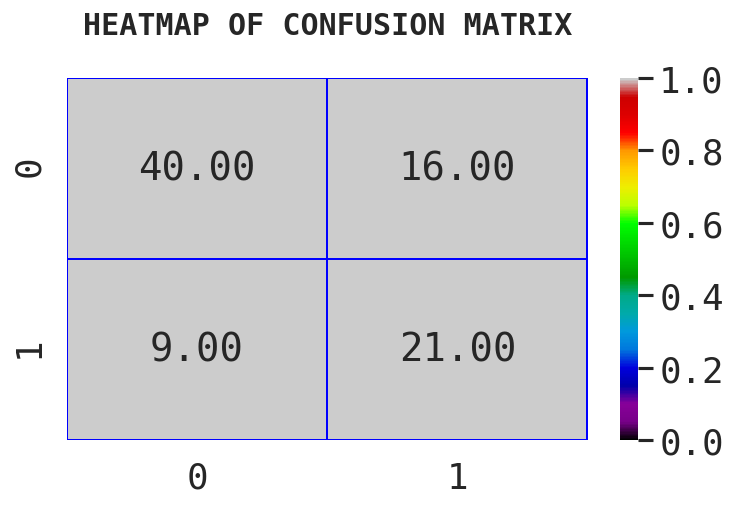



Processing Rating_1 
-------------------------------------
ACCURACY SCORE: 0.7790697674418605

F1 score: 0.3870967741935484

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.85      0.88      0.87        69
           1       0.43      0.35      0.39        17

    accuracy                           0.78        86
   macro avg       0.64      0.62      0.63        86
weighted avg       0.76      0.78      0.77        86


PRECISION:
 0.42857142857142855

RECALL:
 0.35294117647058826

MEAN SQUARED ERROR:
 0.22093023255813954

ROOT MEAN SQ. ERROR:
 0.47003216119552876

LOG_LOSS: 7.630734282357496

AUC_ROC Score:
 0.6184995737425406

TPR: [0.         0.11594203 1.        ] 
FPR: [0.         0.35294118 1.        ]



	____________________________________________ROC_AUC CURVE_______________________________________________


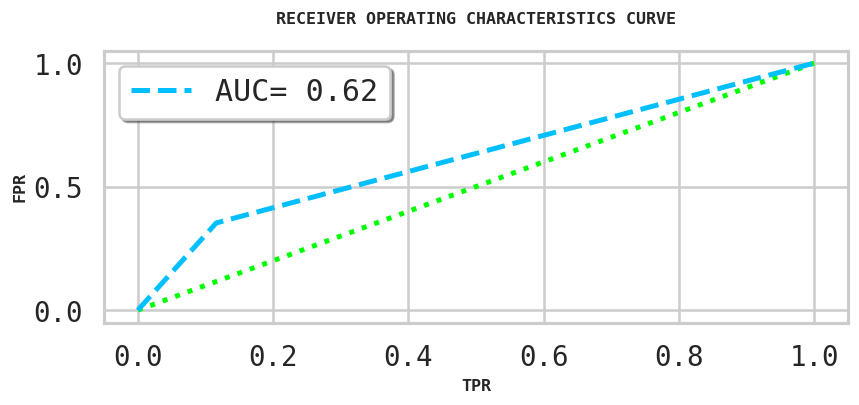




	____________________________________________CONFUSION MATRIX___________________________________________



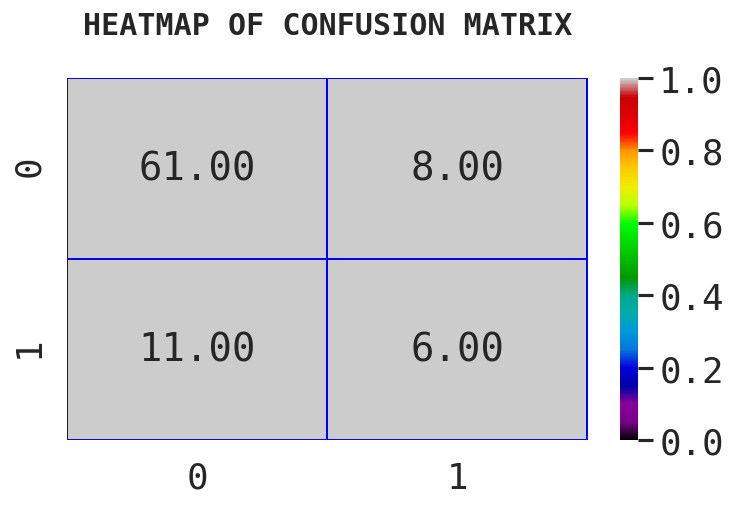



Processing Rating_2 
-------------------------------------
ACCURACY SCORE: 0.7093023255813954

F1 score: 0.13793103448275862

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.76      0.91      0.83        65
           1       0.25      0.10      0.14        21

    accuracy                           0.71        86
   macro avg       0.50      0.50      0.48        86
weighted avg       0.63      0.71      0.66        86


PRECISION:
 0.25

RECALL:
 0.09523809523809523

MEAN SQUARED ERROR:
 0.29069767441860467

ROOT MEAN SQ. ERROR:
 0.5391638660171921

LOG_LOSS: 10.040397761131956

AUC_ROC Score:
 0.5014652014652016

TPR: [0.         0.09230769 1.        ] 
FPR: [0.        0.0952381 1.       ]



	____________________________________________ROC_AUC CURVE_______________________________________________


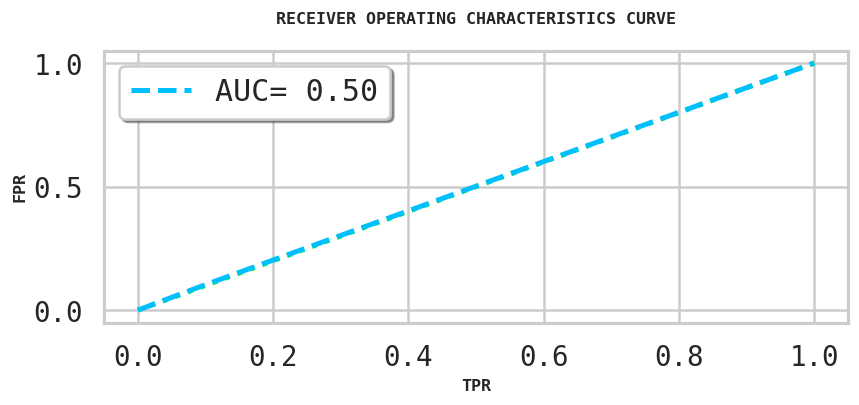




	____________________________________________CONFUSION MATRIX___________________________________________



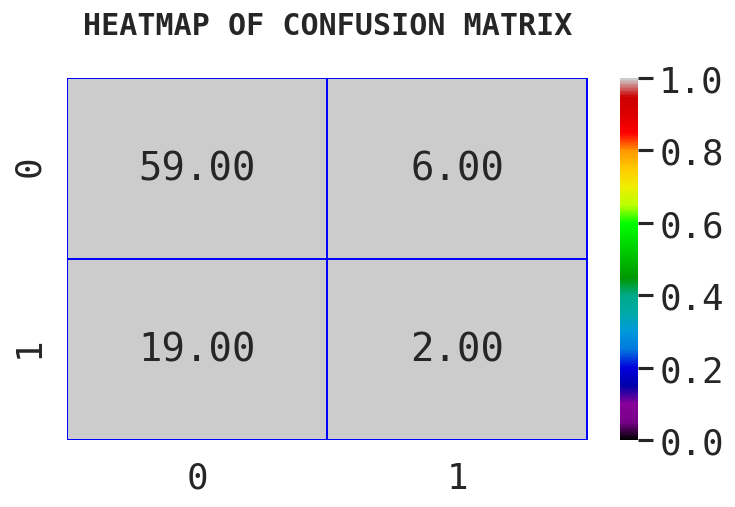



Processing Rating_3 
-------------------------------------
ACCURACY SCORE: 0.7790697674418605

F1 score: 0.09523809523809525

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.80      0.97      0.87        68
           1       0.33      0.06      0.10        18

    accuracy                           0.78        86
   macro avg       0.56      0.51      0.48        86
weighted avg       0.70      0.78      0.71        86


PRECISION:
 0.3333333333333333

RECALL:
 0.05555555555555555

MEAN SQUARED ERROR:
 0.22093023255813954

ROOT MEAN SQ. ERROR:
 0.47003216119552876

LOG_LOSS: 7.6306784964902725

AUC_ROC Score:
 0.5130718954248366

TPR: [0.         0.02941176 1.        ] 
FPR: [0.         0.05555556 1.        ]



	____________________________________________ROC_AUC CURVE_______________________________________________


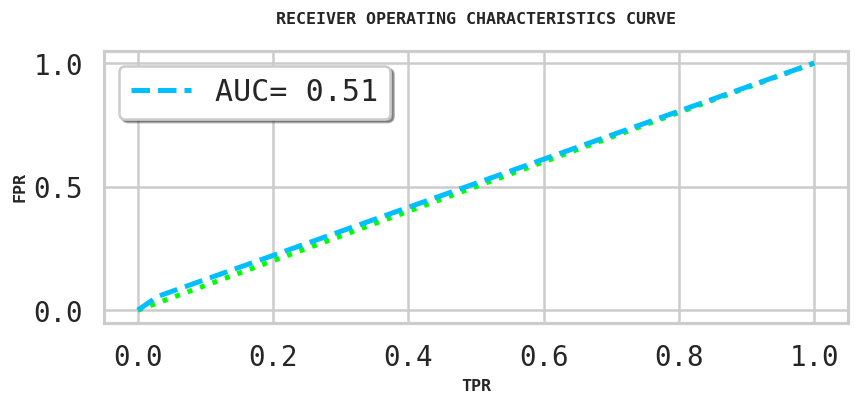




	____________________________________________CONFUSION MATRIX___________________________________________



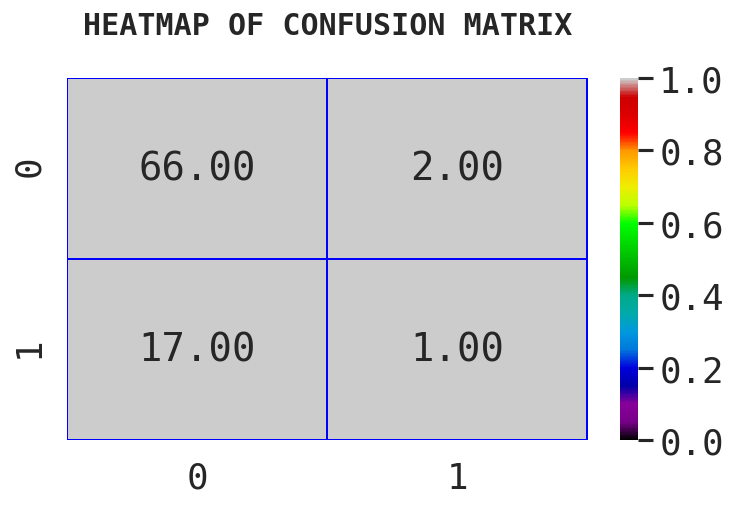



Processing Rating_4 
-------------------------------------
ACCURACY SCORE: 0.8604651162790697

F1 score: 0.3333333333333333

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.89      0.96      0.92        74
           1       0.50      0.25      0.33        12

    accuracy                           0.86        86
   macro avg       0.69      0.60      0.63        86
weighted avg       0.83      0.86      0.84        86


PRECISION:
 0.5

RECALL:
 0.25

MEAN SQUARED ERROR:
 0.13953488372093023

ROOT MEAN SQ. ERROR:
 0.3735436838188142

LOG_LOSS: 4.819392041060683

AUC_ROC Score:
 0.6047297297297297

TPR: [0.         0.04054054 1.        ] 
FPR: [0.   0.25 1.  ]



	____________________________________________ROC_AUC CURVE_______________________________________________


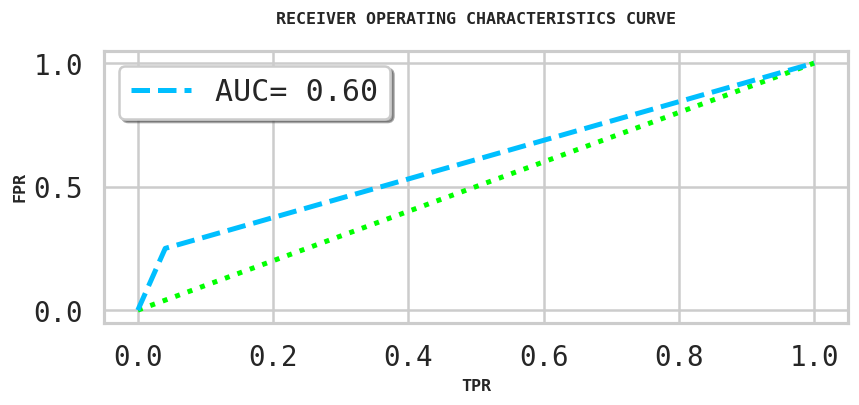




	____________________________________________CONFUSION MATRIX___________________________________________



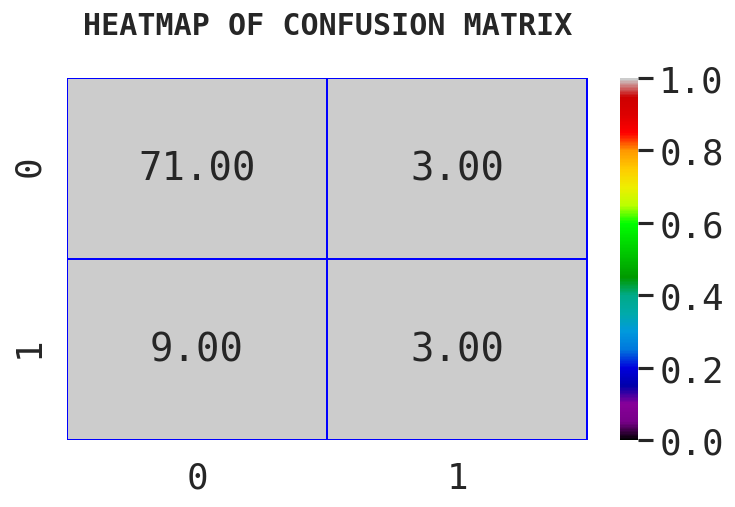



Processing Rating_5 
-------------------------------------
ACCURACY SCORE: 0.7674418604651163

F1 score: 0.2857142857142857

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.82      0.91      0.86        68
           1       0.40      0.22      0.29        18

    accuracy                           0.77        86
   macro avg       0.61      0.57      0.57        86
weighted avg       0.73      0.77      0.74        86


PRECISION:
 0.4

RECALL:
 0.2222222222222222

MEAN SQUARED ERROR:
 0.23255813953488372

ROOT MEAN SQ. ERROR:
 0.4822428221704121

LOG_LOSS: 8.03232936607901

AUC_ROC Score:
 0.5669934640522876

TPR: [0.         0.08823529 1.        ] 
FPR: [0.         0.22222222 1.        ]



	____________________________________________ROC_AUC CURVE_______________________________________________


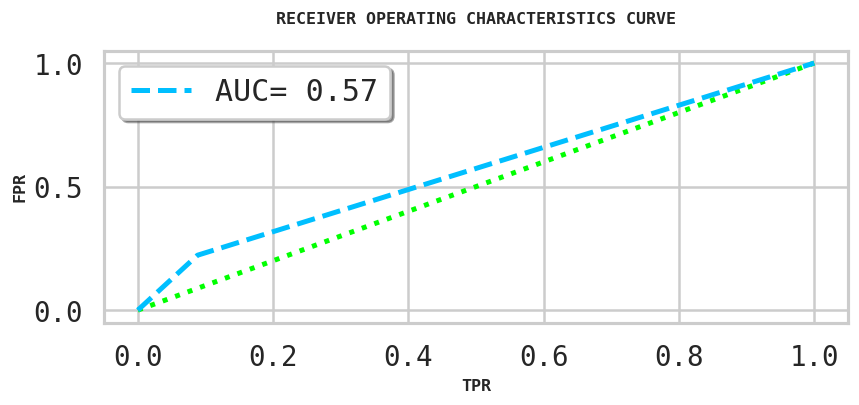




	____________________________________________CONFUSION MATRIX___________________________________________



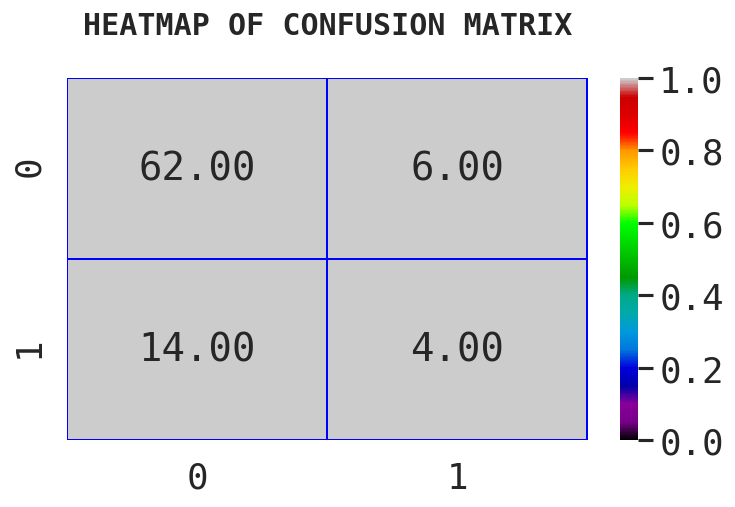

In [621]:
CNB_pipeline = Pipeline([('clf', OneVsRestClassifier(ComplementNB(fit_prior=True, class_prior=None), n_jobs=-1))])
F1=[]
ACCURACY = []
PRECESION = []
RECALL = []
RMSE = []
MSE = []
AUC=[]
TPR=[]
FPR=[]
CV_ACC=[]
LOG_LOSS=[]
for category in labels:
    print('Processing {}'.format(category),'\n-------------------------------------')
    CNB_pipeline.fit(tfidf_train, y_train[category])
    pred = CNB_pipeline.predict(tfidf_test)
    f1=f1_score(pred,y_test[category])
    acc=accuracy_score(pred,y_test[category])
    clr=classification_report(y_test[category],pred)
    pre=precision_score(y_test[category],pred)
    rec=recall_score(y_test[category],pred)
    mse=mean_squared_error(y_test[category],pred)
    rmse=np.sqrt(mse)
    log = log_loss( y_test[category],pred)
    auc_scr=roc_auc_score(y_test[category],pred)
    tpr,fpr,threshold=roc_curve(y_test[category],pred)
    conf=confusion_matrix(y_test[category],pred)
        

    print('ACCURACY SCORE:', acc)
    print('\nF1 score:',f1)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)
    print('\nLOG_LOSS:',log)
    print('\nAUC_ROC Score:\n',auc_scr)
    print('\nTPR:',tpr,'\nFPR:',fpr)
   
    print('\n\n\n\t____________________________________________ROC_AUC CURVE_______________________________________________')
    
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(8,3),dpi=120)
    plt.plot([0,1],[0,1],color='lime',linestyle=":",lw=3)
    plt.plot(tpr,fpr,label="AUC= %0.2f" % auc_scr,color='deepskyblue',lw=3,linestyle='--')
    plt.legend(fancybox=True,shadow=True, fontsize='medium')
    
    plt.xlabel("TPR",weight='bold',fontsize=10)
    plt.ylabel('FPR',weight='bold',fontsize=10)
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE\n',size=10,weight='bold',loc='center')
    plt.show()

    print('\n\n\n\t____________________________________________CONFUSION MATRIX___________________________________________\n')
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1.3)
    plt.figure(figsize=(7,4),dpi=120)
    sns.heatmap(conf,annot=True,fmt='.2f',vmax=1,vmin=0,cmap='nipy_spectral',linewidths=0.8, linecolor='blue')
    plt.title('HEATMAP OF CONFUSION MATRIX\n',size=18,weight='bold',loc='center')
    plt.show()
    print('\n')
    ACCURACY.append(acc)
    F1.append(f1)
    PRECESION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    AUC.append(auc_scr)
    TPR.append(tpr)
    FPR.append(fpr)
    LOG_LOSS.append(log)

cnb_results = pd.DataFrame({"LABELS":labels,"F1":F1,'Acuracy':ACCURACY,'Precision': PRECESION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,'AUC':AUC,'LOG_LOSS':LOG_LOSS})
cnb_results.style.set_properties(**{'background-color':'black','color': 'lime','border-color': 'darkorange'})


Processing overall 
-------------------------------------
ACCURACY SCORE: 0.7093023255813954

F1 score: 0.626865671641791

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.82      0.71      0.76        56
           1       0.57      0.70      0.63        30

    accuracy                           0.71        86
   macro avg       0.69      0.71      0.69        86
weighted avg       0.73      0.71      0.71        86


PRECISION:
 0.5675675675675675

RECALL:
 0.7

MEAN SQUARED ERROR:
 0.29069767441860467

ROOT MEAN SQ. ERROR:
 0.5391638660171921

LOG_LOSS: 10.040490737577327

AUC_ROC Score:
 0.7071428571428571

TPR: [0.         0.28571429 1.        ] 
FPR: [0.  0.7 1. ]



	____________________________________________ROC_AUC CURVE_______________________________________________


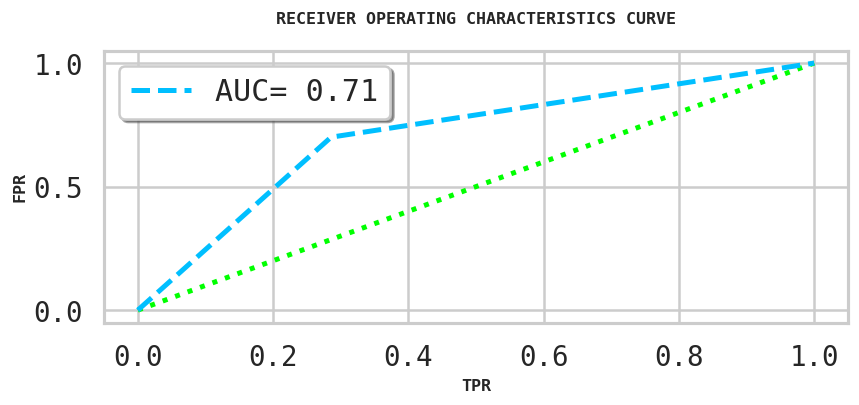




	____________________________________________CONFUSION MATRIX___________________________________________



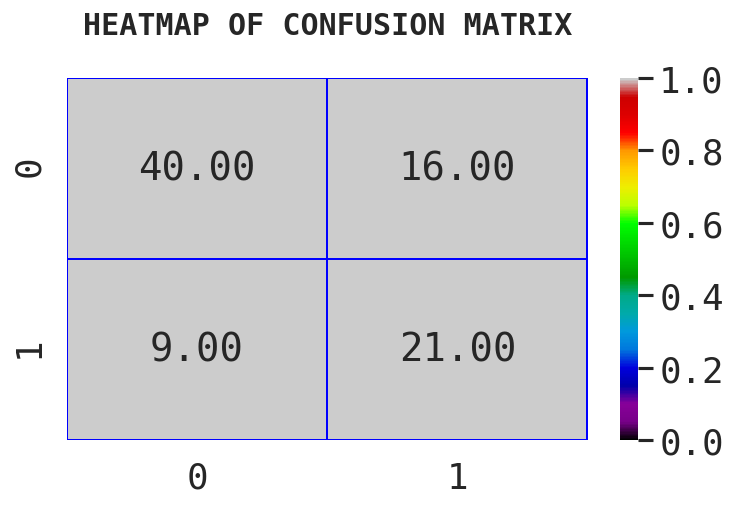



Processing Rating_1 
-------------------------------------
ACCURACY SCORE: 0.7790697674418605

F1 score: 0.3870967741935484

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.85      0.88      0.87        69
           1       0.43      0.35      0.39        17

    accuracy                           0.78        86
   macro avg       0.64      0.62      0.63        86
weighted avg       0.76      0.78      0.77        86


PRECISION:
 0.42857142857142855

RECALL:
 0.35294117647058826

MEAN SQUARED ERROR:
 0.22093023255813954

ROOT MEAN SQ. ERROR:
 0.47003216119552876

LOG_LOSS: 7.630734282357496

AUC_ROC Score:
 0.6184995737425406

TPR: [0.         0.11594203 1.        ] 
FPR: [0.         0.35294118 1.        ]



	____________________________________________ROC_AUC CURVE_______________________________________________


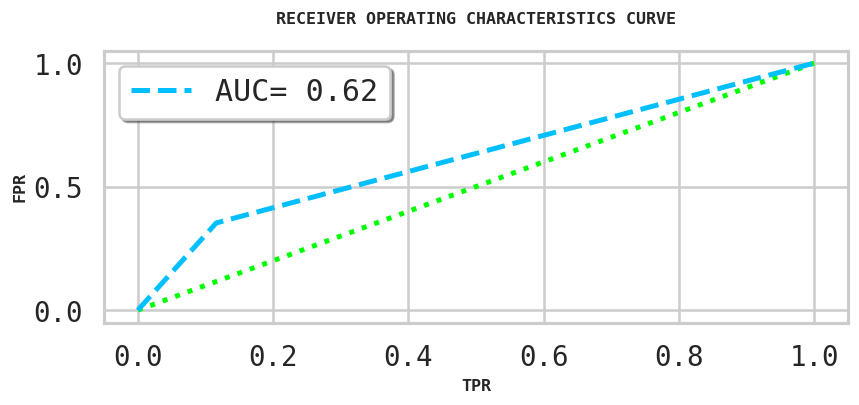




	____________________________________________CONFUSION MATRIX___________________________________________



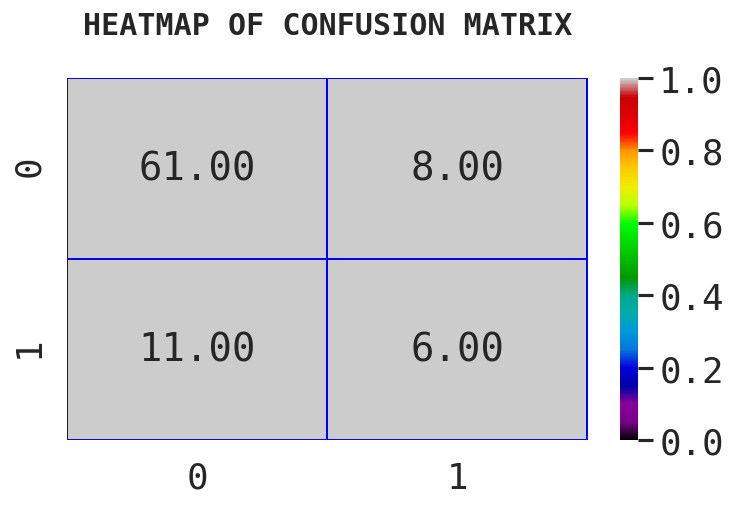



Processing Rating_2 
-------------------------------------
ACCURACY SCORE: 0.7093023255813954

F1 score: 0.13793103448275862

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.76      0.91      0.83        65
           1       0.25      0.10      0.14        21

    accuracy                           0.71        86
   macro avg       0.50      0.50      0.48        86
weighted avg       0.63      0.71      0.66        86


PRECISION:
 0.25

RECALL:
 0.09523809523809523

MEAN SQUARED ERROR:
 0.29069767441860467

ROOT MEAN SQ. ERROR:
 0.5391638660171921

LOG_LOSS: 10.040397761131956

AUC_ROC Score:
 0.5014652014652016

TPR: [0.         0.09230769 1.        ] 
FPR: [0.        0.0952381 1.       ]



	____________________________________________ROC_AUC CURVE_______________________________________________


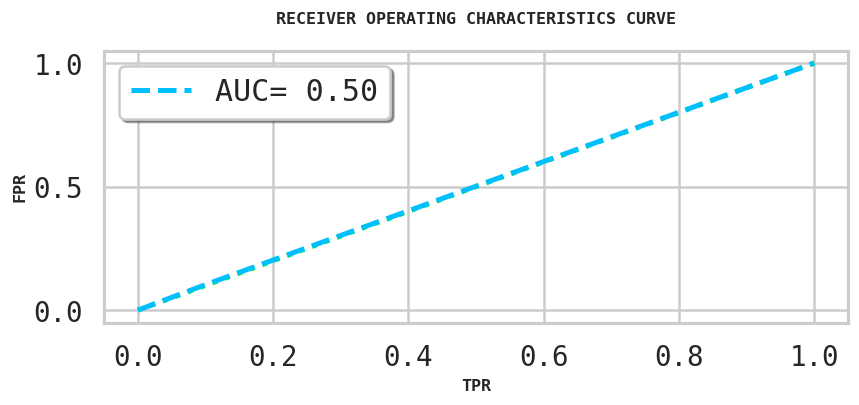




	____________________________________________CONFUSION MATRIX___________________________________________



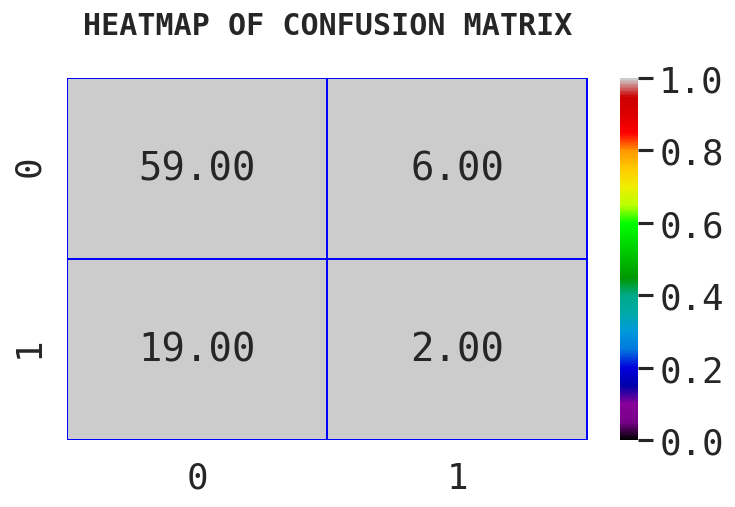



Processing Rating_3 
-------------------------------------
ACCURACY SCORE: 0.7790697674418605

F1 score: 0.09523809523809525

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.80      0.97      0.87        68
           1       0.33      0.06      0.10        18

    accuracy                           0.78        86
   macro avg       0.56      0.51      0.48        86
weighted avg       0.70      0.78      0.71        86


PRECISION:
 0.3333333333333333

RECALL:
 0.05555555555555555

MEAN SQUARED ERROR:
 0.22093023255813954

ROOT MEAN SQ. ERROR:
 0.47003216119552876

LOG_LOSS: 7.6306784964902725

AUC_ROC Score:
 0.5130718954248366

TPR: [0.         0.02941176 1.        ] 
FPR: [0.         0.05555556 1.        ]



	____________________________________________ROC_AUC CURVE_______________________________________________


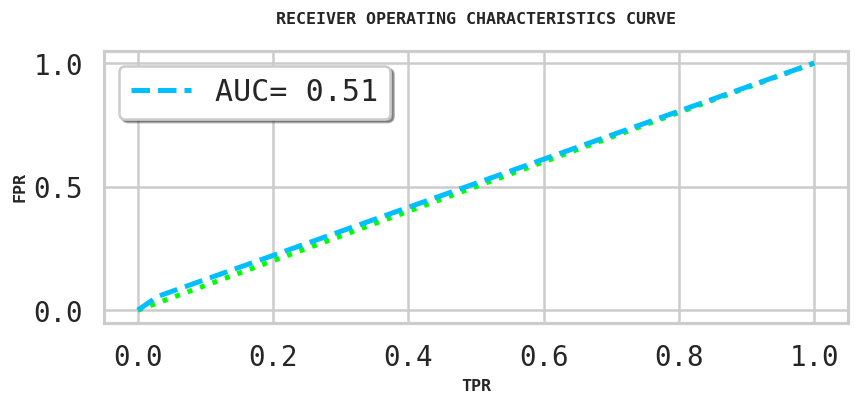




	____________________________________________CONFUSION MATRIX___________________________________________



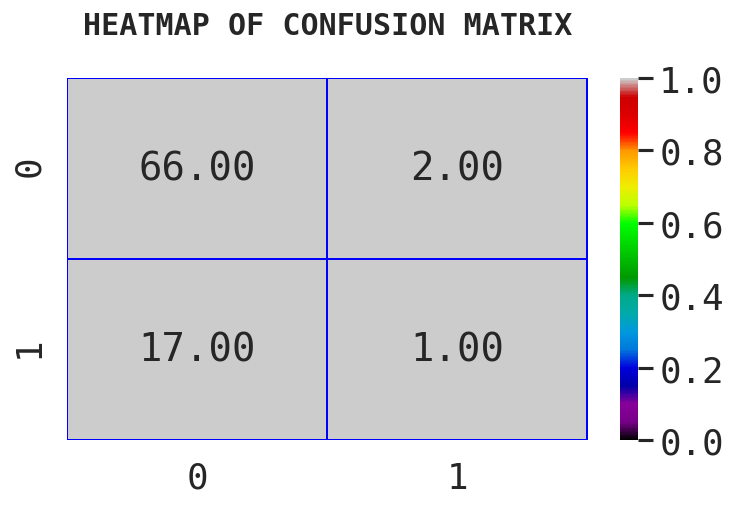



Processing Rating_4 
-------------------------------------
ACCURACY SCORE: 0.8604651162790697

F1 score: 0.3333333333333333

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.89      0.96      0.92        74
           1       0.50      0.25      0.33        12

    accuracy                           0.86        86
   macro avg       0.69      0.60      0.63        86
weighted avg       0.83      0.86      0.84        86


PRECISION:
 0.5

RECALL:
 0.25

MEAN SQUARED ERROR:
 0.13953488372093023

ROOT MEAN SQ. ERROR:
 0.3735436838188142

LOG_LOSS: 4.819392041060683

AUC_ROC Score:
 0.6047297297297297

TPR: [0.         0.04054054 1.        ] 
FPR: [0.   0.25 1.  ]



	____________________________________________ROC_AUC CURVE_______________________________________________


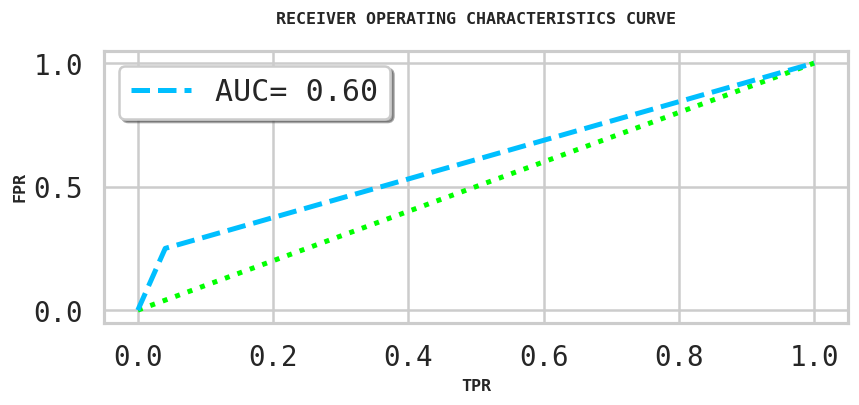




	____________________________________________CONFUSION MATRIX___________________________________________



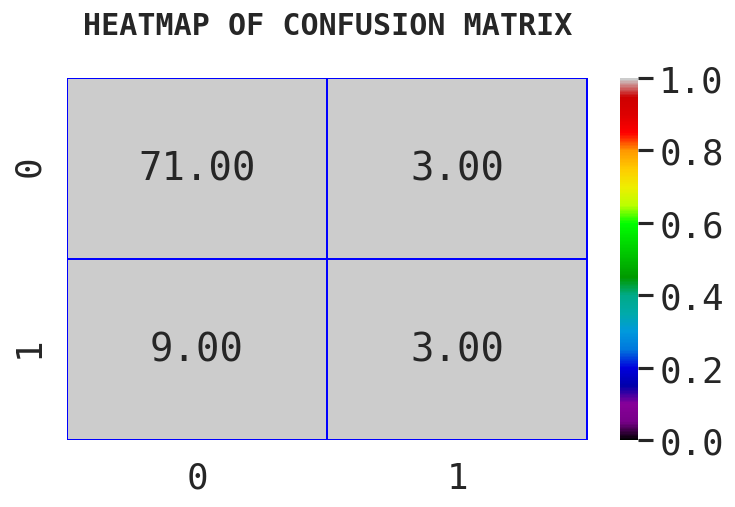



Processing Rating_5 
-------------------------------------
ACCURACY SCORE: 0.7674418604651163

F1 score: 0.2857142857142857

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.82      0.91      0.86        68
           1       0.40      0.22      0.29        18

    accuracy                           0.77        86
   macro avg       0.61      0.57      0.57        86
weighted avg       0.73      0.77      0.74        86


PRECISION:
 0.4

RECALL:
 0.2222222222222222

MEAN SQUARED ERROR:
 0.23255813953488372

ROOT MEAN SQ. ERROR:
 0.4822428221704121

LOG_LOSS: 8.03232936607901

AUC_ROC Score:
 0.5669934640522876

TPR: [0.         0.08823529 1.        ] 
FPR: [0.         0.22222222 1.        ]



	____________________________________________ROC_AUC CURVE_______________________________________________


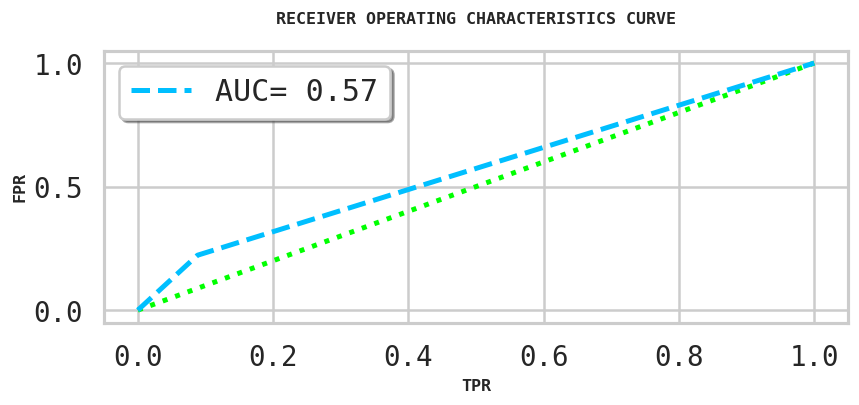




	____________________________________________CONFUSION MATRIX___________________________________________



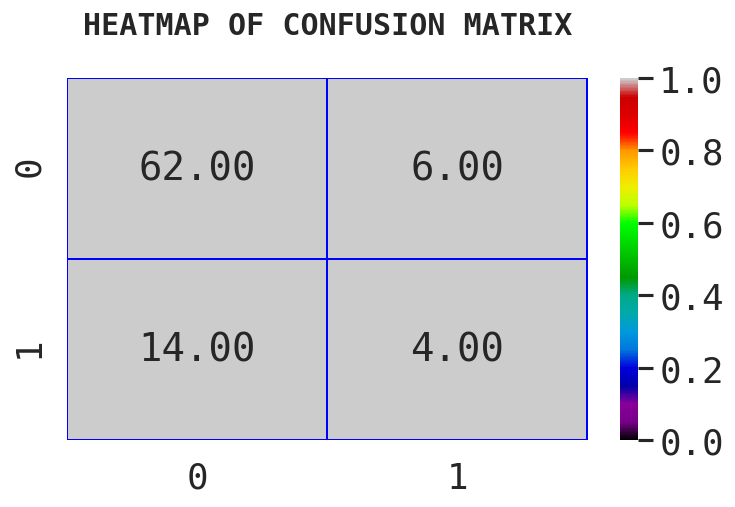

In [622]:
svc_pipeline = Pipeline([('clf', OneVsRestClassifier(ComplementNB(fit_prior=True, class_prior=None), n_jobs=-1))])
F1=[]
ACCURACY = []
PRECESION = []
RECALL = []
RMSE = []
MSE = []
AUC=[]
TPR=[]
FPR=[]
CV_ACC=[]
LOG_LOSS=[]
for category in labels:
    print('Processing {}'.format(category),'\n-------------------------------------')
   
    svc_pipeline.fit(tfidf_train, y_train[category])
    pred = svc_pipeline.predict(tfidf_test)
    f1=f1_score(pred,y_test[category])
    acc=accuracy_score(pred,y_test[category])
    clr=classification_report(y_test[category],pred)
    pre=precision_score(y_test[category],pred)
    rec=recall_score(y_test[category],pred)
    mse=mean_squared_error(y_test[category],pred)
    rmse=np.sqrt(mse)
    log = log_loss( y_test[category],pred)
    auc_scr=roc_auc_score(y_test[category],pred)
    tpr,fpr,threshold=roc_curve(y_test[category],pred)
    conf=confusion_matrix(y_test[category],pred)
        

    print('ACCURACY SCORE:', acc)
    print('\nF1 score:',f1)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)
    print('\nLOG_LOSS:',log)
    print('\nAUC_ROC Score:\n',auc_scr)
    print('\nTPR:',tpr,'\nFPR:',fpr)

    print('\n\n\n\t____________________________________________ROC_AUC CURVE_______________________________________________')

    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(8,3),dpi=120)
    plt.plot([0,1],[0,1],color='lime',linestyle=":",lw=3)
    plt.plot(tpr,fpr,label="AUC= %0.2f" % auc_scr,color='deepskyblue',lw=3,linestyle='--')
    plt.legend(fancybox=True,shadow=True, fontsize='medium')
    
    plt.xlabel("TPR",weight='bold',fontsize=10)
    plt.ylabel('FPR',weight='bold',fontsize=10)
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE\n',size=10,weight='bold',loc='center')
    plt.show()

    print('\n\n\n\t____________________________________________CONFUSION MATRIX___________________________________________\n')
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1.3)
    plt.figure(figsize=(7,4),dpi=120)
    sns.heatmap(conf,annot=True,fmt='.2f',vmax=1,vmin=0,cmap='nipy_spectral',linewidths=0.8, linecolor='blue')
    plt.title('HEATMAP OF CONFUSION MATRIX\n',size=18,weight='bold',loc='center')
    plt.show()
    print('\n')
    ACCURACY.append(acc)
    F1.append(f1)
    PRECESION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    AUC.append(auc_scr)
    TPR.append(tpr)
    FPR.append(fpr)
    LOG_LOSS.append(log)

lsvc_results = pd.DataFrame({"LABELS":labels,"F1":F1,'Acuracy':ACCURACY,'Precision': PRECESION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,'AUC':AUC,'LOG_LOSS':LOG_LOSS})
lsvc_results.style.set_properties(**{'background-color':'black','color': 'lime','border-color': 'darkorange'})

Processing overall 
-------------------------------------
ACCURACY SCORE: 0.7558139534883721

F1 score: 0.6181818181818183

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.79      0.86      0.82        56
           1       0.68      0.57      0.62        30

    accuracy                           0.76        86
   macro avg       0.73      0.71      0.72        86
weighted avg       0.75      0.76      0.75        86


PRECISION:
 0.68

RECALL:
 0.5666666666666667

MEAN SQUARED ERROR:
 0.2441860465116279

ROOT MEAN SQ. ERROR:
 0.4941518456017623

LOG_LOSS: 8.433961640378675

AUC_ROC Score:
 0.7119047619047619

TPR: [0.         0.14285714 1.        ] 
FPR: [0.         0.56666667 1.        ]



	____________________________________________ROC_AUC CURVE_______________________________________________


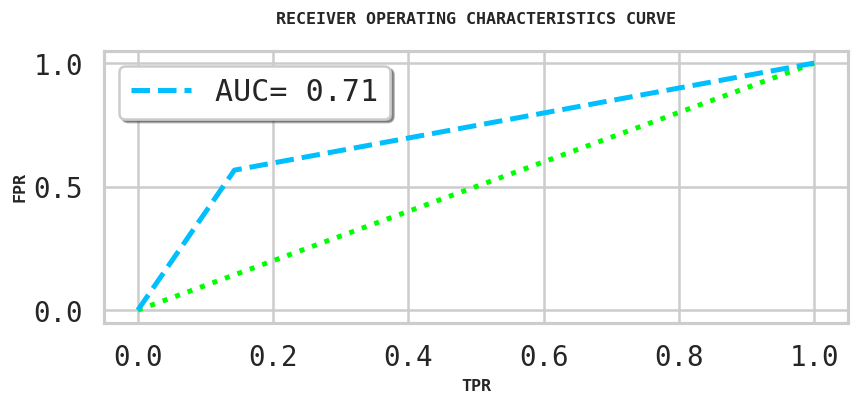




	____________________________________________CONFUSION MATRIX___________________________________________



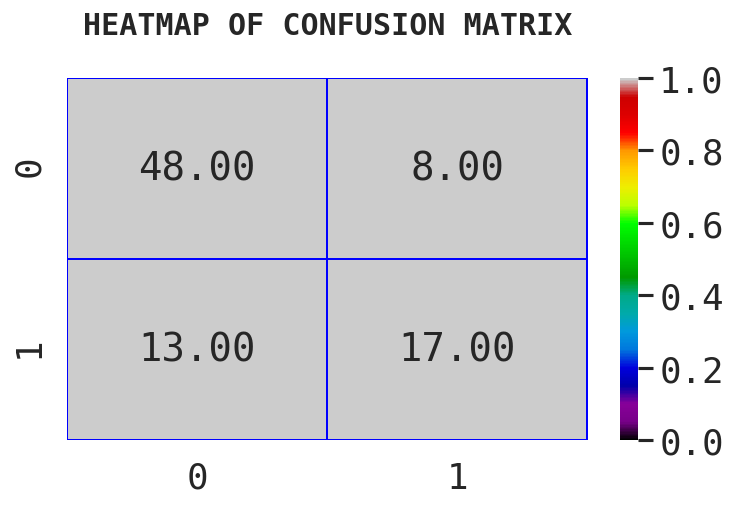



Processing Rating_1 
-------------------------------------
ACCURACY SCORE: 0.7674418604651163

F1 score: 0.23076923076923078

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.82      0.91      0.86        69
           1       0.33      0.18      0.23        17

    accuracy                           0.77        86
   macro avg       0.58      0.54      0.55        86
weighted avg       0.72      0.77      0.74        86


PRECISION:
 0.3333333333333333

RECALL:
 0.17647058823529413

MEAN SQUARED ERROR:
 0.23255813953488372

ROOT MEAN SQ. ERROR:
 0.4822428221704121

LOG_LOSS: 8.03232936607901

AUC_ROC Score:
 0.5447570332480819

TPR: [0.         0.08695652 1.        ] 
FPR: [0.         0.17647059 1.        ]



	____________________________________________ROC_AUC CURVE_______________________________________________


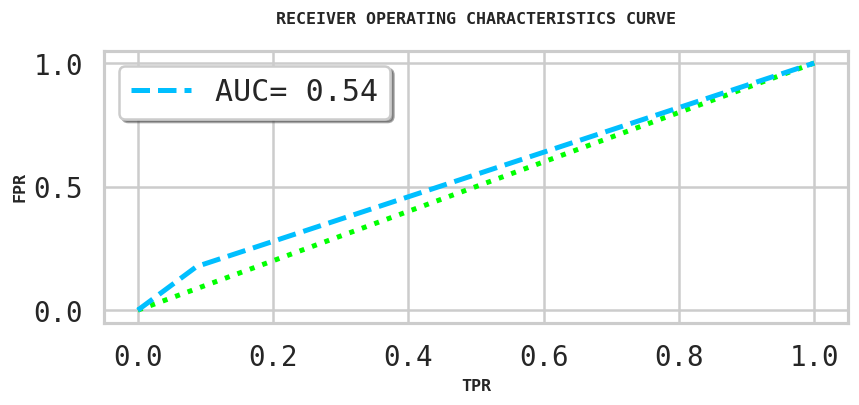




	____________________________________________CONFUSION MATRIX___________________________________________



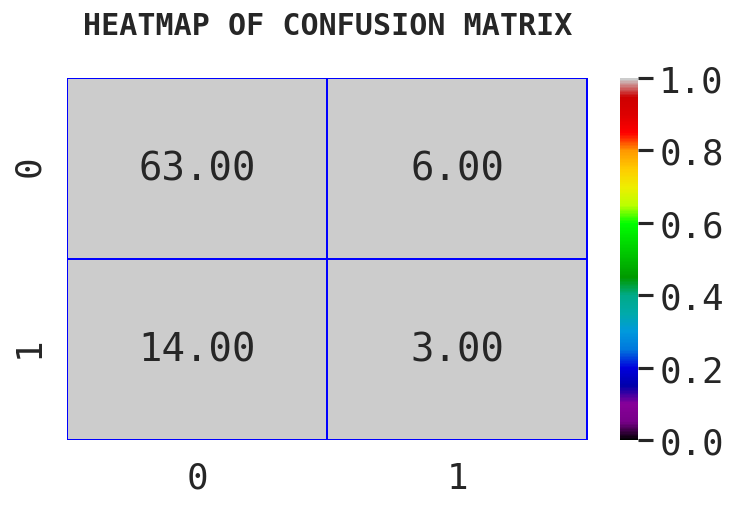



Processing Rating_2 
-------------------------------------
ACCURACY SCORE: 0.7209302325581395

F1 score: 0.14285714285714285

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.76      0.92      0.83        65
           1       0.29      0.10      0.14        21

    accuracy                           0.72        86
   macro avg       0.52      0.51      0.49        86
weighted avg       0.64      0.72      0.66        86


PRECISION:
 0.2857142857142857

RECALL:
 0.09523809523809523

MEAN SQUARED ERROR:
 0.27906976744186046

ROOT MEAN SQ. ERROR:
 0.5282705437953743

LOG_LOSS: 9.63877478447683

AUC_ROC Score:
 0.5091575091575092

TPR: [0.         0.07692308 1.        ] 
FPR: [0.        0.0952381 1.       ]



	____________________________________________ROC_AUC CURVE_______________________________________________


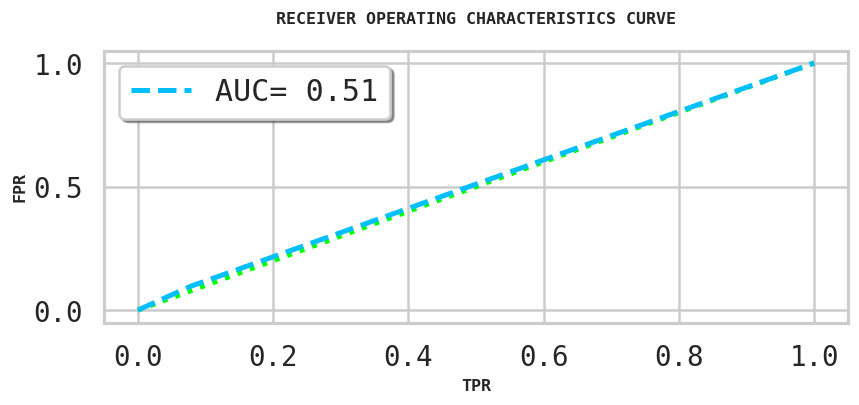




	____________________________________________CONFUSION MATRIX___________________________________________



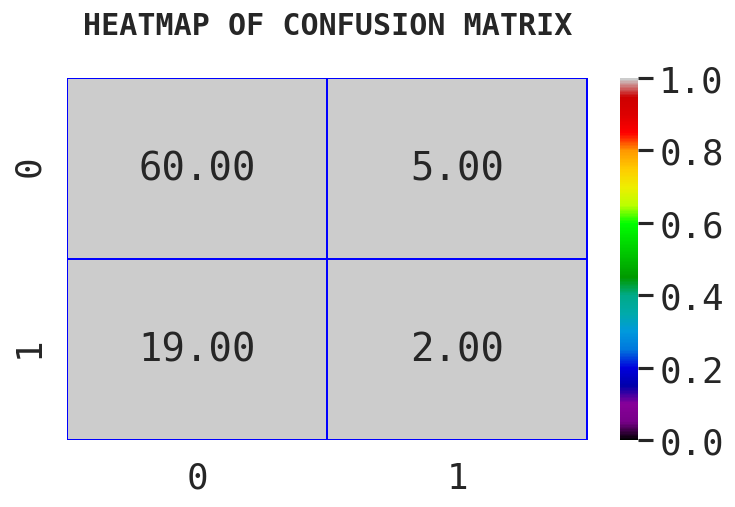



Processing Rating_3 
-------------------------------------
ACCURACY SCORE: 0.7906976744186046

F1 score: 0.1818181818181818

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.80      0.97      0.88        68
           1       0.50      0.11      0.18        18

    accuracy                           0.79        86
   macro avg       0.65      0.54      0.53        86
weighted avg       0.74      0.79      0.73        86


PRECISION:
 0.5

RECALL:
 0.1111111111111111

MEAN SQUARED ERROR:
 0.20930232558139536

ROOT MEAN SQ. ERROR:
 0.457495710997814

LOG_LOSS: 7.229064817479682

AUC_ROC Score:
 0.5408496732026143

TPR: [0.         0.02941176 1.        ] 
FPR: [0.         0.11111111 1.        ]



	____________________________________________ROC_AUC CURVE_______________________________________________


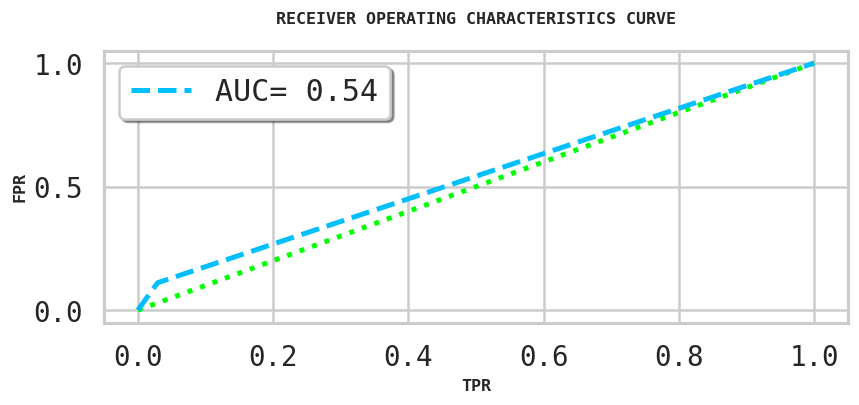




	____________________________________________CONFUSION MATRIX___________________________________________



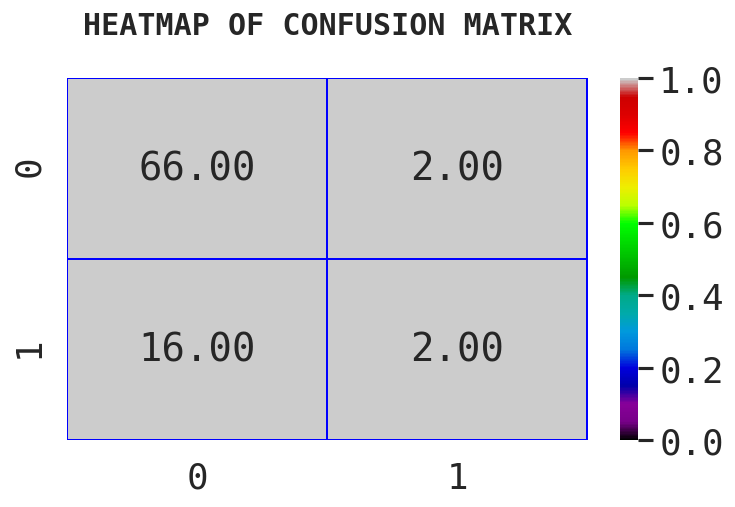



Processing Rating_4 
-------------------------------------
ACCURACY SCORE: 0.7790697674418605

F1 score: 0.17391304347826086

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.87      0.88      0.87        74
           1       0.18      0.17      0.17        12

    accuracy                           0.78        86
   macro avg       0.52      0.52      0.52        86
weighted avg       0.77      0.78      0.78        86


PRECISION:
 0.18181818181818182

RECALL:
 0.16666666666666666

MEAN SQUARED ERROR:
 0.22093023255813954

ROOT MEAN SQ. ERROR:
 0.47003216119552876

LOG_LOSS: 7.630743580002033

AUC_ROC Score:
 0.5225225225225225

TPR: [0.         0.12162162 1.        ] 
FPR: [0.         0.16666667 1.        ]



	____________________________________________ROC_AUC CURVE_______________________________________________


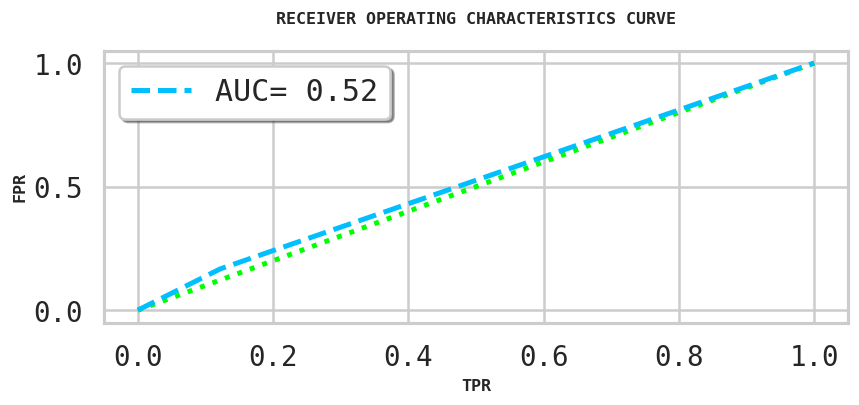




	____________________________________________CONFUSION MATRIX___________________________________________



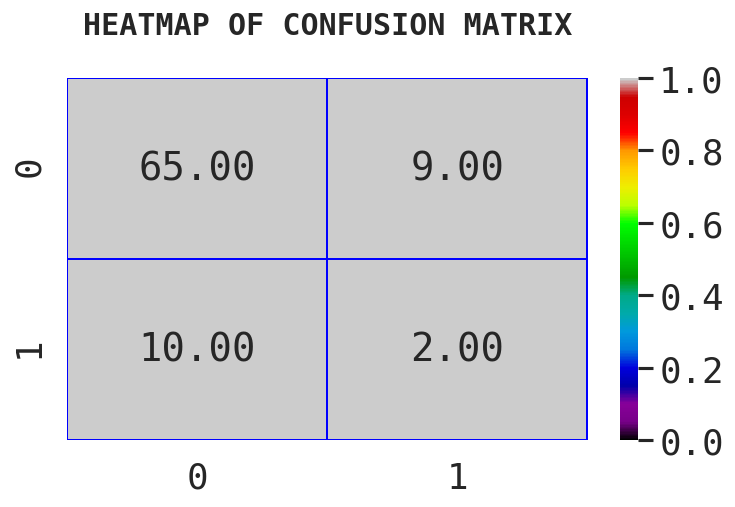



Processing Rating_5 
-------------------------------------
ACCURACY SCORE: 0.8255813953488372

F1 score: 0.4444444444444444

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.84      0.96      0.90        68
           1       0.67      0.33      0.44        18

    accuracy                           0.83        86
   macro avg       0.76      0.64      0.67        86
weighted avg       0.81      0.83      0.80        86


PRECISION:
 0.6666666666666666

RECALL:
 0.3333333333333333

MEAN SQUARED ERROR:
 0.1744186046511628

ROOT MEAN SQ. ERROR:
 0.4176345347922784

LOG_LOSS: 6.024233078092452

AUC_ROC Score:
 0.6446078431372548

TPR: [0.         0.04411765 1.        ] 
FPR: [0.         0.33333333 1.        ]



	____________________________________________ROC_AUC CURVE_______________________________________________


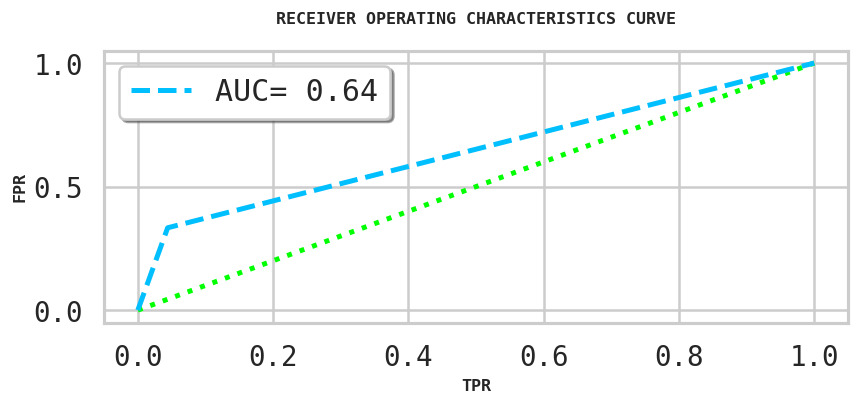




	____________________________________________CONFUSION MATRIX___________________________________________



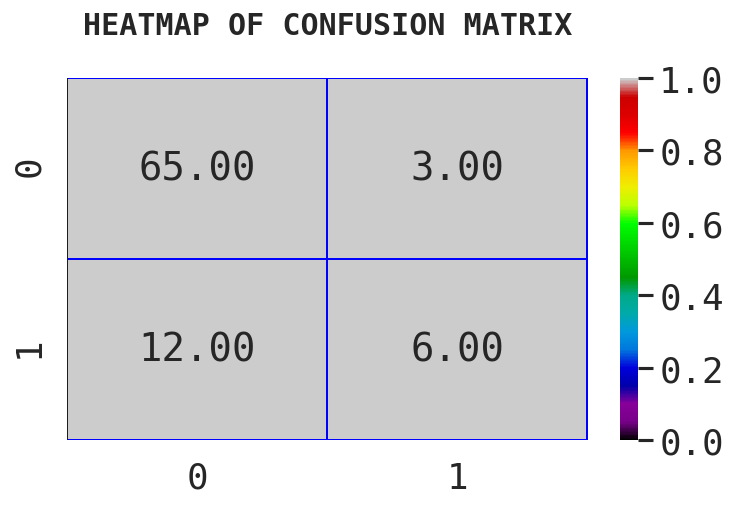

In [624]:
GB_pipeline = Pipeline([('clf', OneVsRestClassifier(GradientBoostingClassifier(),n_jobs=-1))])

F1=[]
ACCURACY = []
PRECESION = []
RECALL = []
RMSE = []
MSE = []
AUC=[]
TPR=[]
FPR=[]
CV_ACC=[]
LOG_LOSS=[]
for category in labels:
    print('Processing {}'.format(category),'\n-------------------------------------')
    
    GB_pipeline.fit(tfidf_train, y_train[category])
    pred = GB_pipeline.predict(tfidf_test)
    f1=f1_score(pred,y_test[category])
    acc=accuracy_score(pred,y_test[category])
    clr=classification_report(y_test[category],pred)
    pre=precision_score(y_test[category],pred)
    rec=recall_score(y_test[category],pred)
    mse=mean_squared_error(y_test[category],pred)
    rmse=np.sqrt(mse)
    log = log_loss( y_test[category],pred)
    auc_scr=roc_auc_score(y_test[category],pred)
    tpr,fpr,threshold=roc_curve(y_test[category],pred)
    conf=confusion_matrix(y_test[category],pred)
        

    print('ACCURACY SCORE:', acc)
    print('\nF1 score:',f1)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)
    print('\nLOG_LOSS:',log)
    print('\nAUC_ROC Score:\n',auc_scr)
    print('\nTPR:',tpr,'\nFPR:',fpr)
    
    print('\n\n\n\t____________________________________________ROC_AUC CURVE_______________________________________________')

    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(8,3),dpi=120)
    plt.plot([0,1],[0,1],color='lime',linestyle=":",lw=3)
    plt.plot(tpr,fpr,label="AUC= %0.2f" % auc_scr,color='deepskyblue',lw=3,linestyle='--')
    plt.legend(fancybox=True,shadow=True, fontsize='medium')
    
    plt.xlabel("TPR",weight='bold',fontsize=10)
    plt.ylabel('FPR',weight='bold',fontsize=10)
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE\n',size=10,weight='bold',loc='center')
    plt.show()

    print('\n\n\n\t____________________________________________CONFUSION MATRIX___________________________________________\n')
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1.3)
    plt.figure(figsize=(7,4),dpi=120)
    sns.heatmap(conf,annot=True,fmt='.2f',vmax=1,vmin=0,cmap='nipy_spectral',linewidths=0.8, linecolor='blue')
    plt.title('HEATMAP OF CONFUSION MATRIX\n',size=18,weight='bold',loc='center')
    plt.show()
    print('\n')
    ACCURACY.append(acc)
    F1.append(f1)
    PRECESION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    AUC.append(auc_scr)
    TPR.append(tpr)
    FPR.append(fpr)
    LOG_LOSS.append(log)

gb_results = pd.DataFrame({"LABELS":labels,"F1":F1,'Acuracy':ACCURACY,'Precision': PRECESION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,'AUC':AUC,'LOG_LOSS':LOG_LOSS})
gb_results.style.set_properties(**{'background-color':'black','color': 'lime','border-color': 'darkorange'})

In [625]:
print('\nRESULTS OBTAINED FROM LOGISTIC REGRESSION\n')
display(logi_results)
print('\nRESULTS OBTAINED FROM PASSIVE AGGRESSIVE CLASSIFIER\n')
display(pac_results)
print('\nRESULTS OBTAINED FROM MULTINOMIAL NB CLASSIFIER\n')
display(mnb_results)
print('\nRESULTS OBTAINED FROM COMPLEMENT NB CLASSIFIER\n')
display(cnb_results)
print('\nRESULTS OBTAINED FROM LINER SVC CLASSIFIER\n')
display(lsvc_results)
print('\nRESULTS OBTAINED FROM GRADIENT BOOSTING CLASSIFIER\n')
display(gb_results)


RESULTS OBTAINED FROM LOGISTIC REGRESSION



LABELS        F1   Acuracy  Precision    Recall  \
0     (o, v, e, r, a, l, l)  0.565217  0.767442     0.8125  0.433333   
1  (R, a, t, i, n, g, _, 1)  0.000000  0.802326     0.0000  0.000000   
2  (R, a, t, i, n, g, _, 2)  0.000000  0.755814     0.0000  0.000000   
3  (R, a, t, i, n, g, _, 3)  0.000000  0.790698     0.0000  0.000000   
4  (R, a, t, i, n, g, _, 4)  0.000000  0.860465     0.0000  0.000000   
5  (R, a, t, i, n, g, _, 5)  0.000000  0.790698     0.0000  0.000000   

       RMSE       MSE       AUC  LOG_LOSS  
0  0.482243  0.232558  0.689881  8.032301  
1  0.444606  0.197674  0.500000  6.827433  
2  0.494152  0.244186  0.500000  8.433887  
3  0.457496  0.209302  0.500000  7.229046  
4  0.373544  0.139535  0.500000  4.819364  
5  0.457496  0.209302  0.500000  7.229046


RESULTS OBTAINED FROM PASSIVE AGGRESSIVE CLASSIFIER



LABELS        F1   Acuracy  Precision    Recall  \
0     (o, v, e, r, a, l, l)  0.612903  0.720930   0.593750  0.633333   
1  (R, a, t, i, n, g, _, 1)  0.451613  0.802326   0.500000  0.411765   
2  (R, a, t, i, n, g, _, 2)  0.242424  0.709302   0.333333  0.190476   
3  (R, a, t, i, n, g, _, 3)  0.083333  0.744186   0.166667  0.055556   
4  (R, a, t, i, n, g, _, 4)  0.260870  0.802326   0.272727  0.250000   
5  (R, a, t, i, n, g, _, 5)  0.307692  0.790698   0.500000  0.222222   

       RMSE       MSE       AUC   LOG_LOSS  
0  0.528271  0.279070  0.700595   9.638849  
1  0.444606  0.197674  0.655158   6.827498  
2  0.539164  0.290698  0.533700  10.040416  
3  0.505781  0.255814  0.491013   8.835547  
4  0.444606  0.197674  0.570946   6.827507  
5  0.457496  0.209302  0.581699   7.229083


RESULTS OBTAINED FROM MULTINOMIAL NB CLASSIFIER



LABELS        F1   Acuracy  Precision  Recall      RMSE  \
0     (o, v, e, r, a, l, l)  0.533333  0.755814        0.8     0.4  0.494152   
1  (R, a, t, i, n, g, _, 1)  0.000000  0.790698        0.0     0.0  0.457496   
2  (R, a, t, i, n, g, _, 2)  0.000000  0.755814        0.0     0.0  0.494152   
3  (R, a, t, i, n, g, _, 3)  0.000000  0.790698        0.0     0.0  0.457496   
4  (R, a, t, i, n, g, _, 4)  0.000000  0.860465        0.0     0.0  0.373544   
5  (R, a, t, i, n, g, _, 5)  0.000000  0.790698        0.0     0.0  0.457496   

        MSE       AUC  LOG_LOSS  
0  0.244186  0.673214  8.433915  
1  0.209302  0.492754  7.229056  
2  0.244186  0.500000  8.433887  
3  0.209302  0.500000  7.229046  
4  0.139535  0.500000  4.819364  
5  0.209302  0.500000  7.229046


RESULTS OBTAINED FROM COMPLEMENT NB CLASSIFIER



LABELS        F1   Acuracy  Precision    Recall  \
0     (o, v, e, r, a, l, l)  0.626866  0.709302   0.567568  0.700000   
1  (R, a, t, i, n, g, _, 1)  0.387097  0.779070   0.428571  0.352941   
2  (R, a, t, i, n, g, _, 2)  0.137931  0.709302   0.250000  0.095238   
3  (R, a, t, i, n, g, _, 3)  0.095238  0.779070   0.333333  0.055556   
4  (R, a, t, i, n, g, _, 4)  0.333333  0.860465   0.500000  0.250000   
5  (R, a, t, i, n, g, _, 5)  0.285714  0.767442   0.400000  0.222222   

       RMSE       MSE       AUC   LOG_LOSS  
0  0.539164  0.290698  0.707143  10.040491  
1  0.470032  0.220930  0.618500   7.630734  
2  0.539164  0.290698  0.501465  10.040398  
3  0.470032  0.220930  0.513072   7.630678  
4  0.373544  0.139535  0.604730   4.819392  
5  0.482243  0.232558  0.566993   8.032329


RESULTS OBTAINED FROM LINER SVC CLASSIFIER



LABELS        F1   Acuracy  Precision    Recall  \
0     (o, v, e, r, a, l, l)  0.626866  0.709302   0.567568  0.700000   
1  (R, a, t, i, n, g, _, 1)  0.387097  0.779070   0.428571  0.352941   
2  (R, a, t, i, n, g, _, 2)  0.137931  0.709302   0.250000  0.095238   
3  (R, a, t, i, n, g, _, 3)  0.095238  0.779070   0.333333  0.055556   
4  (R, a, t, i, n, g, _, 4)  0.333333  0.860465   0.500000  0.250000   
5  (R, a, t, i, n, g, _, 5)  0.285714  0.767442   0.400000  0.222222   

       RMSE       MSE       AUC   LOG_LOSS  
0  0.539164  0.290698  0.707143  10.040491  
1  0.470032  0.220930  0.618500   7.630734  
2  0.539164  0.290698  0.501465  10.040398  
3  0.470032  0.220930  0.513072   7.630678  
4  0.373544  0.139535  0.604730   4.819392  
5  0.482243  0.232558  0.566993   8.032329


RESULTS OBTAINED FROM GRADIENT BOOSTING CLASSIFIER



LABELS        F1   Acuracy  Precision    Recall  \
0     (o, v, e, r, a, l, l)  0.618182  0.755814   0.680000  0.566667   
1  (R, a, t, i, n, g, _, 1)  0.230769  0.767442   0.333333  0.176471   
2  (R, a, t, i, n, g, _, 2)  0.142857  0.720930   0.285714  0.095238   
3  (R, a, t, i, n, g, _, 3)  0.181818  0.790698   0.500000  0.111111   
4  (R, a, t, i, n, g, _, 4)  0.173913  0.779070   0.181818  0.166667   
5  (R, a, t, i, n, g, _, 5)  0.444444  0.825581   0.666667  0.333333   

       RMSE       MSE       AUC  LOG_LOSS  
0  0.494152  0.244186  0.711905  8.433962  
1  0.482243  0.232558  0.544757  8.032329  
2  0.528271  0.279070  0.509158  9.638775  
3  0.457496  0.209302  0.540850  7.229065  
4  0.470032  0.220930  0.522523  7.630744  
5  0.417635  0.174419  0.644608  6.024233

Choosing GB as final model because its Accuracy Score is high.

In [627]:
joblib.dump(GB_pipeline,'Rpp_Comments.pkl')
print('MOdle Saved')

MOdle Saved


In [628]:
#loading the model
model=joblib.load('Rpp_Comments.pkl')

In [630]:
df.head()

Text  raw length  overall  \
0  I have always been a Samsung cell phone person...         464        1   
1  Everything about the cell phone looked good. B...         875        0   
2  Mobile phones are cost-effective, high in pixe...         115        1   
3  I was hesitant to buy a brand I've never heard...         185        1   
4  Bought this for my wife and she loves it!! Its...         216        1   

   Rating_1  Rating_2  Rating_3  Rating_4  Rating_5  \
0         0         0         0         0         1   
1         1         0         0         0         0   
2         0         0         0         0         1   
3         0         0         0         0         1   
4         0         0         0         0         1   

                                             comment  len of cleaned comment  
0  alway samsung cell phone person tcl phone felt...                     226  
1  cell phone good tri hold custom servic help st...                     426  
2        mobil phone high pixel excel perform worthi                      43  
3  hesit buy brand heard absolut love total worth...                      97  
4  bought wife love nice note high price well bat...                     104

In [631]:
X=df['comment']
X

0      alway samsung cell phone person tcl phone felt...
1      cell phone good tri hold custom servic help st...
2            mobil phone high pixel excel perform worthi
3      hesit buy brand heard absolut love total worth...
4      bought wife love nice note high price well bat...
                             ...                        
425    use note sfe work phone featur miss deep press...
426    phone camera good featur truli awesom btw phon...
427    think pay phone least put protect case damn th...
428    havent phone month love anyth screen develop h...
429    switch phone googl pixel set first problem inc...
Name: comment, Length: 430, dtype: object

In [633]:
tfidf_vec = TfidfVectorizer(input='content', encoding='utf-8', lowercase=True,stop_words='english',max_features=1000,ngram_range=(1,3))
test_x=tfidf_vec.fit_transform(X)


In [634]:
test_x.shape

(430, 1000)

In [635]:
result=model.predict(test_x)

In [636]:
display(result)

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,